In [1]:
# TODO: remover perfis do dataset comTE_thickness muito grande ou rever forma de lidar com eles e os pesos juntos
# TODO: ver alguma forma de visualizar o espaço latente (PCA, t-SNE, UMAP), distribuições normal e gerada e os perfis gerados nesse espaço
# TODO: Buscar artigo do beta VAE  e KL Annealing e entender melhor o conceito por trás do BETA
# TODO: Rodar com diferentes estruturas de rede
# TODO: Comparar KL Annealing com betas variados

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
from pathlib import Path
from aerosandbox import Airfoil, KulfanAirfoil

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

from src.vae import CSTVariationalAutoencoder
from src.plotting import plot_original_and_reconstruction
from src.layers.airfoil_scaler import AirfoilScaler

from src.airfoil import airfoil_modifications

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2026-01-31 01:12:21.415717: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-31 01:12:22.104036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-31 01:12:24.538056: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# --- Hyperparameters ---
EPOCHS = 1000 # 5000
PATIENCE = 15  # Quantas épocas esperar antes de reduzir o LR
MIN_DELTA = 0.001 # Mínima melhoria considerada "bom"
DECAY_FACTOR = 0.5 # Corta o LR pela metade

BATCH_SIZE = 32
LATENT_DIM = 16
NPV = 12 # Number of CST coefficients MUST BE EQUAL TO THE ONE USED IN DATASET GENERATION
LEARNING_RATE = 1e-3
CLIPNORM = 1.0  # Gradient clipping norm value
WARMUP_EPOCHS = 1000 # Number of epochs for KL annealing warm-up
TARGET_BETA = 0.005 # Weight for KL Divergence Loss

HYPERPARAMETERS = {
    'epochs': EPOCHS,
    'latent_dim': LATENT_DIM,
    'initial_learning_rate': LEARNING_RATE,
    'target_beta': TARGET_BETA,
    'warmup_epochs': WARMUP_EPOCHS,
    'batch_size': BATCH_SIZE,
    'clipnorm': CLIPNORM,
}


In [4]:
# --- Dataset Loading ---
dataset_path = Path(proj_path) / "data" / "processed" / "kulfan_dataset_75.json"

print("Loading dataset...")
airfoil_dataset = pd.read_json(dataset_path)

# Fix coordinates
airfoil_dataset["coordinates"] = airfoil_dataset["coordinates"].apply(lambda coords: np.array(coords))

display(airfoil_dataset)

# Prepare the data: concatenate lower and upper weights along with TE thickness and leading edge weight
airfoil_data = airfoil_dataset["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"], 
    p["upper_weights"], 
    [p["TE_thickness"]], 
    [p["leading_edge_weight"]]
    ], axis=0)).to_numpy()

airfoil_data = np.stack(airfoil_data, axis=0).astype(np.float32)
  
raw_weights = airfoil_data[:, :-2]
raw_params = airfoil_data[:, -2:]

print(f"Original Dataset Size: {len(raw_params)}")

# Filter 1: Reasonable Thickness (e.g., < 5cm)
# If your data is normalized, ensure this check happens on raw physical values
valid_te = raw_params[:, 0] < 0.05 

# Filter 2: Reasonable Weights (e.g., between -2 and 2)
# Any weight larger than this is likely a glitch
valid_weights = np.all((raw_weights > -2.0) & (raw_weights < 2.0), axis=1)

# Combine and Apply
valid_mask = valid_te & valid_weights
raw_weights = raw_weights[valid_mask]
raw_params = raw_params[valid_mask]

print(f"Cleaned Dataset Size: {len(raw_params)}")

# Now fit the scaler on clean data
scaler = AirfoilScaler()
scaler.fit(raw_weights, raw_params)
print(f"Max Weight Value: {np.max(scaler.w_max)}")
print(f"Max Param Value: {np.max(scaler.p_max)}")

normalized_data = scaler.transform(raw_weights, raw_params)

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_data)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)
print(f"Dataset loaded and normalized: {len(normalized_data)} samples")
print(
    f"Data Range Check -> Min: {normalized_data.min():.2f}, Max: {normalized_data.max():.2f}"
)

# Picking airfoils for validation and plotting
validation_airfoils_df = airfoil_dataset.sample(n=9, random_state=SEED).reset_index(drop=True)
validation_airfoils = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df.to_dict(orient="records")]

validation_input = validation_airfoils_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"], 
    p["upper_weights"], 
    [p["TE_thickness"]], 
    [p["leading_edge_weight"]]
    ], axis=0)).to_list()


Loading dataset...


,airfoil_name,coordinates,kulfan_parameters,shape,points,lower_weights,upper_weights,TE_thickness,leading_edge_weight
0,2032c,"[[1.0, 0.0016], [0.9995417967, 0.0016995265], ...","{'lower_weights': [-0.10683679110000001, -0.14...","[149, 2]",149,"[-0.10683679110000001, -0.1485625107, 0.326924...","[0.0948583634, 0.21107414060000002, 0.38171045...",0.003200,0.656100
1,a18,"[[0.999952181, 0.0030692550000000003], [0.9995...","{'lower_weights': [-0.0748249423, 0.1111120356...","[149, 2]",149,"[-0.0748249423, 0.1111120356, -0.265417391, 0....","[0.14708768900000002, 0.3742670319, -0.1052206...",0.006124,-0.451487
2,a18sm,"[[1.0000000153, 0.003065], [0.9995529208, 0.00...","{'lower_weights': [-0.1149933895, -0.083876534...","[149, 2]",149,"[-0.1149933895, -0.0838765345, -0.0039501749, ...","[0.1160734576, 0.1398997753, 0.1959743786, 0.0...",0.006122,0.124729
3,a63a108c,"[[1.0000122498, 0.0034999571], [0.9995549037, ...","{'lower_weights': [-0.1416319728, 0.1800977121...","[149, 2]",149,"[-0.1416319728, 0.1800977121, -0.7514766111000...","[0.216615688, 0.0282372011, 0.5080533458000001...",0.007224,-0.226960
4,ag03,"[[1.0000001216, 0.0006050018], [0.99954566, 0....","{'lower_weights': [-0.0678305205, -0.099856330...","[149, 2]",149,"[-0.0678305205, -0.0998563303, 0.0803733244, -...","[0.1232144149, 0.1532735559, 0.0848064727, 0.2...",0.001176,0.096844
...,...,...,...,...,...,...,...,...,...
2019,Zone-25,"[[1.0000002714, 0.00032499650000000004], [0.99...","{'lower_weights': [-0.08496360010000001, -0.05...","[149, 2]",149,"[-0.08496360010000001, -0.054415347, -0.068800...","[0.11170654220000001, 0.11175453590000001, 0.0...",0.000628,0.105904
2020,Zone-36,"[[1.0000001524, 0.0003349966], [0.9995453662, ...","{'lower_weights': [-0.0931942593, -0.095020682...","[149, 2]",149,"[-0.0931942593, -0.0950206821, 0.0076843382000...","[0.1011650033, 0.0605159761, 0.1925498675, -0....",0.000632,0.220925
2021,Zone-40,"[[1.000000063, 0.0003499965], [0.9995449988, 0...","{'lower_weights': [-0.10342949, -0.1374248823,...","[149, 2]",149,"[-0.10342949, -0.1374248823, 0.066304542000000...","[0.0918992446, 0.0239927314, 0.252088309, -0.1...",0.000656,0.337661
2022,Zone-46,"[[1.0000000456, 0.0003649963], [0.9995447776, ...","{'lower_weights': [-0.1043008089, -0.146396046...","[149, 2]",149,"[-0.1043008089, -0.1463960461, 0.0823624048, -...","[0.092267365, 0.024931859900000002, 0.26582232...",0.000682,0.353729


Original Dataset Size: 2024
Cleaned Dataset Size: 1530
Max Weight Value: 1.9972431659698486
Max Param Value: 1.964417815208435
Dataset loaded and normalized: 1530 samples
Data Range Check -> Min: -1.00, Max: 1.00


2026-01-31 01:12:27.201553: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


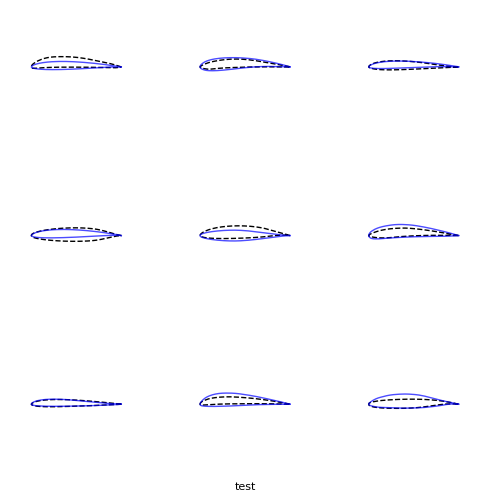

In [5]:
# Randomly sample 9 rows from the DataFrame
validation_airfoils_df = airfoil_dataset.sample(n=9, random_state=SEED)
validation_airfoils = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df.to_dict(orient="records")]

validation_airfoils_df_2 = airfoil_dataset.sample(n=9, random_state=1)
validation_airfoils_2 = [Airfoil(coordinates=af["coordinates"], name=af["airfoil_name"]) for af in validation_airfoils_df_2.to_dict(orient="records")]

plot_original_and_reconstruction(validation_airfoils, validation_airfoils_2, text_label="test")

In [6]:
# --- Instantiate Model, Optimizer, and Loss ---
vae = CSTVariationalAutoencoder(scaler, npv=NPV, latent_dim=LATENT_DIM)

best_loss = float('inf')
wait = 0
current_lr = LEARNING_RATE  # Seu LR inicial
optimizer = tf.keras.optimizers.Adam(learning_rate=current_lr, clipnorm=CLIPNORM)

# Main Loss (Reconstruction Loss)
# reconstruction_loss = tf.keras.losses.MeanSquaredError()
reconstruction_loss = tf.keras.losses.MeanAbsoluteError()

# --- Training Step (for one batch) ---
@tf.function
def train_step(data, beta):
    """
    Runs one training step with robust Sum-Squared Error loss.
    """
    with tf.GradientTape() as tape:
        # 1. Forward Pass
        # training=True enables the SamplingLayer noise
        reconstruction = vae(data, training=True)
        _, pred_weights, pred_params = reconstruction
        
        # 2. Split Targets
        # data shape: (Batch, 26)
        true_weights, true_params = tf.split(data, [2 * NPV, 2], axis=1)

        # 3. Flatten Predictions for Loss Calculation
        # pred_weights shape is (Batch, 2, 12) -> Flatten to (Batch, 24)
        pred_weights_flat = tf.reshape(pred_weights, [-1, 2 * NPV])

        # 4. Calculate Reconstruction Loss (Sum of Squares)
        # We use SUM to match the magnitude of the physics
        loss_weights = tf.reduce_mean(tf.reduce_sum(tf.square(true_weights - pred_weights_flat), axis=1))
        loss_params = tf.reduce_mean(tf.reduce_sum(tf.square(true_params - pred_params), axis=1))
        
        reco_loss = loss_weights + loss_params
        
        # 5. KL Loss (Already calculated inside the model via self.add_loss)
        kl_loss = sum(vae.losses)

        # 6. Total Loss
        total_loss = reco_loss + (beta * kl_loss)

    # 7. Backpropagation
    grads = tape.gradient(total_loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    
    return total_loss, reco_loss, kl_loss

Sanity Check: Training on a fixed batch of 4 airfoils...


/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'encoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'decoder_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 0: Loss = 15.76183
Epoch 20: Loss = 1.61908
Epoch 40: Loss = 0.34805
Epoch 60: Loss = 0.09483
Epoch 80: Loss = 0.03324
Epoch 100: Loss = 0.01194
Epoch 120: Loss = 0.01511
Epoch 140: Loss = 0.01511
Epoch 160: Loss = 0.00353
Epoch 180: Loss = 0.00372
Epoch 200: Loss = 0.00894
Epoch 220: Loss = 0.00400
Epoch 240: Loss = 0.00592
Epoch 260: Loss = 0.00638
Epoch 280: Loss = 0.00279
Epoch 300: Loss = 0.00253
Epoch 320: Loss = 0.00326
Epoch 340: Loss = 0.00178
Epoch 360: Loss = 0.00344
Epoch 380: Loss = 0.00697
Epoch 400: Loss = 0.00512
Epoch 420: Loss = 0.00171
Epoch 440: Loss = 0.00248
Epoch 460: Loss = 0.00306
Epoch 480: Loss = 0.00280
Epoch 500: Loss = 0.00069
Epoch 520: Loss = 0.00132
Epoch 540: Loss = 0.00095
Epoch 560: Loss = 0.00174
Epoch 580: Loss = 0.00156
Training Finished.
Plotting Results...


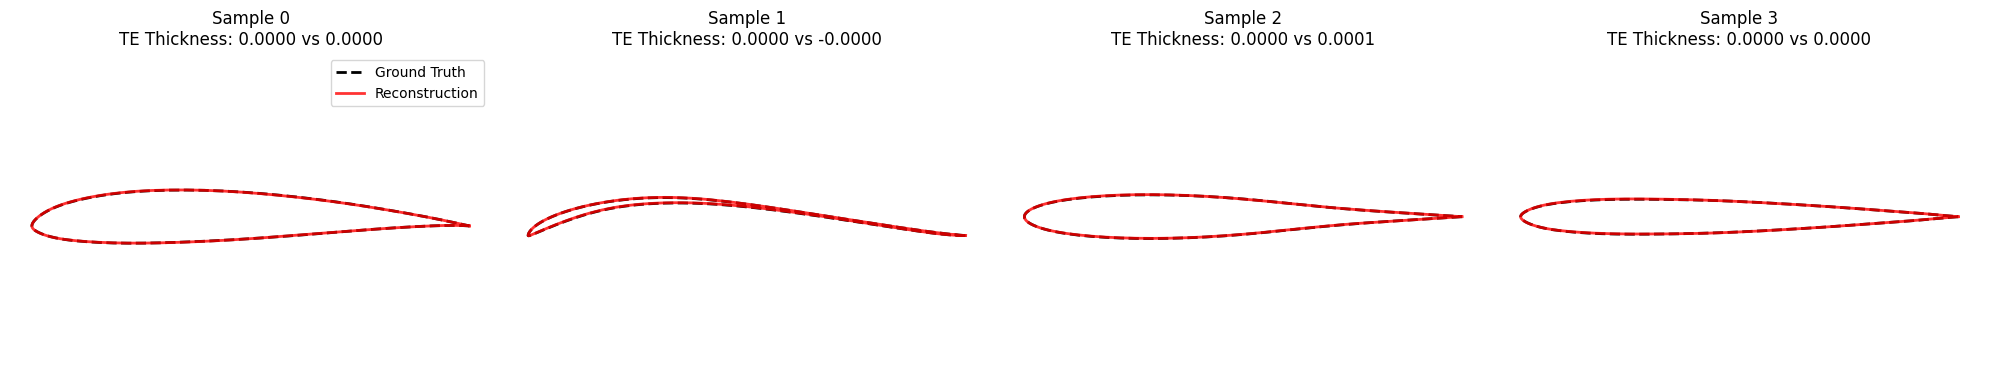

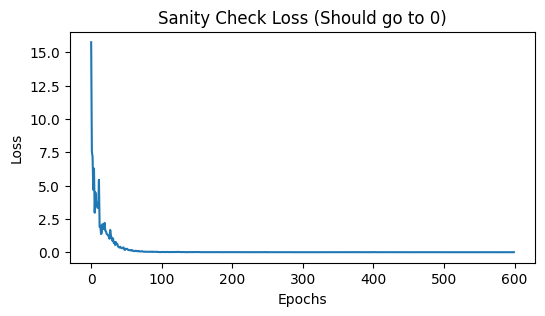

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from aerosandbox import Airfoil

# --- CONFIGURATION ---
SANITY_BATCH_SIZE = 4
SANITY_EPOCHS = 600
NPV = 12  # Ensure this matches your model

# 1. Grab ONE fixed batch of data
# We take 4 samples and repeat them indefinitely to force overfitting
sanity_data = next(iter(train_dataset.unbatch().batch(SANITY_BATCH_SIZE).take(1)))

print(f"Sanity Check: Training on a fixed batch of {SANITY_BATCH_SIZE} airfoils...")

# 2. Re-initialize Model (Optional: Start fresh to ensure no old weights interfere)
# If you want to test your CURRENT model state, comment these two lines out.
vae = CSTVariationalAutoencoder(npv=NPV, latent_dim=16, scaler=scaler) 
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)

# 3. The Overfitting Loop
loss_history = []

for epoch in range(SANITY_EPOCHS):
    with tf.GradientTape() as tape:
        # Forward Pass
        # We split the output: (Coordinates, Weights, Params)
        # Note: We ignore coordinates from the model output for the loss calculation
        _, pred_weights, pred_params = vae(sanity_data, training=True)
        
        # Split the Ground Truth Data
        true_weights, true_params = tf.split(sanity_data, [2 * NPV, 2], axis=1)

        # --- FIX: FLATTEN PREDICTIONS BEFORE SUBTRACTION ---
        # pred_weights comes out as (Batch, 2, 12). We need (Batch, 24).
        pred_weights_flat = tf.reshape(pred_weights, [-1, 2 * NPV])

        # Calculate PURE Reconstruction Loss
        loss_w = tf.reduce_sum(tf.square(true_weights - pred_weights_flat))
        loss_p = tf.reduce_sum(tf.square(true_params - pred_params))
        
        # NO KL LOSS. We want to see if the model *can* memorize geometry.
        total_loss = loss_w + loss_p

    # Backpropagation
    grads = tape.gradient(total_loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    
    loss_history.append(total_loss.numpy())

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.numpy():.5f}")

print("Training Finished.")

# --- 4. VISUALIZATION ---
print("Plotting Results...")

# A. Prepare Ground Truth (Denormalize -> CST Transform)
true_weights_norm, true_params_norm = tf.split(sanity_data, [2 * NPV, 2], axis=1)
t_w_phys, t_p_phys = vae.scaler.inverse_transform(true_weights_norm.numpy(), true_params_norm.numpy())

# B. Prepare Prediction (Denormalize -> CST Transform)
_, pred_w_norm, pred_p_norm = vae(sanity_data, training=False)
p_w_phys, p_p_phys = vae.scaler.inverse_transform(pred_w_norm.numpy(), pred_p_norm.numpy())

# C. Generate Coordinates using YOUR Model's Internal Layer
# This ensures we see exactly what the model "thinks" the shape is.
# Ground Truth Coords
gt_coords = vae.decoder.cst_transform(
    tf.convert_to_tensor(t_w_phys, dtype=tf.float32), 
    tf.convert_to_tensor(t_p_phys, dtype=tf.float32)
).numpy()

# Predicted Coords
pred_coords = vae.decoder.cst_transform(
    tf.convert_to_tensor(p_w_phys, dtype=tf.float32), 
    tf.convert_to_tensor(p_p_phys, dtype=tf.float32)
).numpy()

# D. Plot
fig, axes = plt.subplots(1, SANITY_BATCH_SIZE, figsize=(20, 4))
if SANITY_BATCH_SIZE == 1: axes = [axes]

for i, ax in enumerate(axes):
    # Plot Ground Truth (Black Dashed)
    ax.plot(gt_coords[i][:, 0], gt_coords[i][:, 1], 'k--', linewidth=2, label="Ground Truth")
    
    # Plot Prediction (Red Solid)
    ax.plot(pred_coords[i][:, 0], pred_coords[i][:, 1], 'r-', linewidth=2, alpha=0.8, label="Reconstruction")
    
    ax.set_title(f"Sample {i}\nTE Thickness: {t_p_phys[i][0]:.4f} vs {p_p_phys[i][0]:.4f}")
    ax.axis('equal')
    ax.axis('off')
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

# E. Plot Loss Curve
plt.figure(figsize=(6,3))
plt.plot(loss_history)
plt.title("Sanity Check Loss (Should go to 0)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/matsouto/.netrc.
wandb: Currently logged in as: matsouto (matsouto-universidade-federal-da-bahia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training...


Epoch 1/1000:   0%|          | 0/48 [00:00<?, ?it/s]/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
Epoch 1/1000: 100%|██████████| 48/

Epoch 1/1000, Time: 2.85s, Total Loss: 1.3490, Reco Loss: 1.3490, KL Loss: 0.9673
Generating and plotting airfoils...


Epoch 2/1000: 100%|██████████| 48/48 [00:01<00:00, 26.76it/s]


Epoch 2/1000, Time: 4.73s, Total Loss: 0.4259, Reco Loss: 0.4259, KL Loss: 2.9217
Generating and plotting airfoils...


Epoch 3/1000: 100%|██████████| 48/48 [00:01<00:00, 30.00it/s]


Epoch 3/1000, Time: 6.36s, Total Loss: 0.1857, Reco Loss: 0.1857, KL Loss: 3.6962
Generating and plotting airfoils...


Epoch 4/1000: 100%|██████████| 48/48 [00:01<00:00, 29.94it/s]


Epoch 4/1000, Time: 8.00s, Total Loss: 0.1271, Reco Loss: 0.1271, KL Loss: 4.1176
Generating and plotting airfoils...


Epoch 5/1000: 100%|██████████| 48/48 [00:01<00:00, 30.16it/s]


Epoch 5/1000, Time: 9.62s, Total Loss: 0.1089, Reco Loss: 0.1088, KL Loss: 4.3292
Generating and plotting airfoils...


Epoch 6/1000: 100%|██████████| 48/48 [00:01<00:00, 28.33it/s]


Epoch 6/1000, Time: 11.35s, Total Loss: 0.0873, Reco Loss: 0.0872, KL Loss: 4.4675
Generating and plotting airfoils...


Epoch 7/1000: 100%|██████████| 48/48 [00:01<00:00, 29.12it/s]


Epoch 7/1000, Time: 13.03s, Total Loss: 0.0784, Reco Loss: 0.0782, KL Loss: 4.6063
Generating and plotting airfoils...


Epoch 8/1000: 100%|██████████| 48/48 [00:01<00:00, 28.12it/s]


Epoch 8/1000, Time: 14.77s, Total Loss: 0.0627, Reco Loss: 0.0625, KL Loss: 4.6960
Generating and plotting airfoils...


Epoch 9/1000: 100%|██████████| 48/48 [00:00<00:00, -56.87it/s]


Epoch 9/1000, Time: 13.96s, Total Loss: 0.0512, Reco Loss: 0.0511, KL Loss: 4.8435
Generating and plotting airfoils...


Epoch 10/1000: 100%|██████████| 48/48 [00:01<00:00, 24.77it/s]

Epoch 10/1000, Time: 15.93s, Total Loss: 0.0476, Reco Loss: 0.0474, KL Loss: 4.9267
Generating and plotting airfoils...


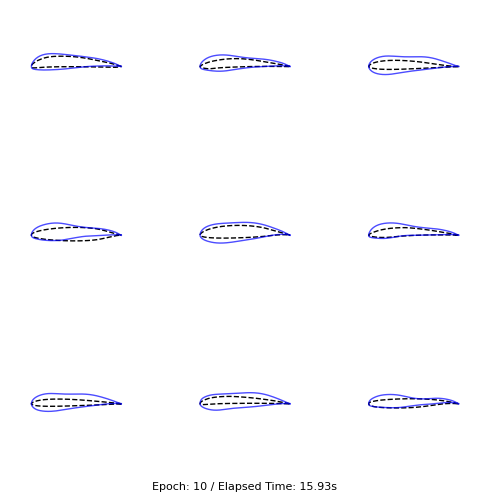

Epoch 11/1000: 100%|██████████| 48/48 [00:01<00:00, 29.05it/s]


Epoch 11/1000, Time: 17.67s, Total Loss: 0.0386, Reco Loss: 0.0383, KL Loss: 5.0117
Generating and plotting airfoils...


Epoch 12/1000: 100%|██████████| 48/48 [00:01<00:00, 29.24it/s]


Epoch 12/1000, Time: 19.34s, Total Loss: 0.0360, Reco Loss: 0.0357, KL Loss: 5.1105
Generating and plotting airfoils...


Epoch 13/1000: 100%|██████████| 48/48 [00:01<00:00, 28.85it/s]


Epoch 13/1000, Time: 21.04s, Total Loss: 0.0328, Reco Loss: 0.0325, KL Loss: 5.1413
Generating and plotting airfoils...


Epoch 14/1000: 100%|██████████| 48/48 [00:01<00:00, 28.62it/s]


Epoch 14/1000, Time: 22.75s, Total Loss: 0.0314, Reco Loss: 0.0311, KL Loss: 5.1264
Generating and plotting airfoils...


Epoch 15/1000: 100%|██████████| 48/48 [00:01<00:00, 28.79it/s]


Epoch 15/1000, Time: 24.45s, Total Loss: 0.0285, Reco Loss: 0.0281, KL Loss: 5.1377
Generating and plotting airfoils...


Epoch 16/1000: 100%|██████████| 48/48 [00:01<00:00, 29.03it/s]


Epoch 16/1000, Time: 26.14s, Total Loss: 0.0280, Reco Loss: 0.0277, KL Loss: 5.1455
Generating and plotting airfoils...


Epoch 17/1000: 100%|██████████| 48/48 [00:01<00:00, 26.65it/s]


Epoch 17/1000, Time: 27.97s, Total Loss: 0.0269, Reco Loss: 0.0264, KL Loss: 5.1184
Generating and plotting airfoils...


Epoch 18/1000: 100%|██████████| 48/48 [00:01<00:00, 29.50it/s]


Epoch 18/1000, Time: 29.63s, Total Loss: 0.0238, Reco Loss: 0.0233, KL Loss: 5.1254
Generating and plotting airfoils...


Epoch 19/1000: 100%|██████████| 48/48 [00:01<00:00, 28.65it/s]


Epoch 19/1000, Time: 31.34s, Total Loss: 0.0222, Reco Loss: 0.0217, KL Loss: 5.1615
Generating and plotting airfoils...


Epoch 20/1000: 100%|██████████| 48/48 [00:01<00:00, 29.04it/s]

Epoch 20/1000, Time: 33.03s, Total Loss: 0.0207, Reco Loss: 0.0202, KL Loss: 5.2004
Generating and plotting airfoils...


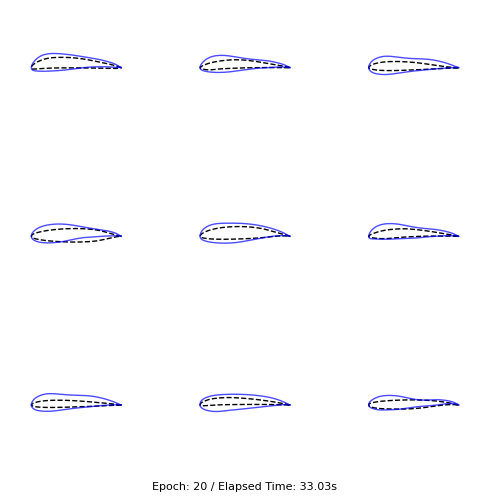

Epoch 21/1000: 100%|██████████| 48/48 [00:01<00:00, 27.22it/s]


Epoch 21/1000, Time: 34.87s, Total Loss: 0.0201, Reco Loss: 0.0196, KL Loss: 5.2284
Generating and plotting airfoils...


Epoch 22/1000: 100%|██████████| 48/48 [00:01<00:00, 29.03it/s]


Epoch 22/1000, Time: 36.56s, Total Loss: 0.0204, Reco Loss: 0.0198, KL Loss: 5.2250
Generating and plotting airfoils...


Epoch 23/1000: 100%|██████████| 48/48 [00:01<00:00, 29.42it/s]


Epoch 23/1000, Time: 38.22s, Total Loss: 0.0188, Reco Loss: 0.0182, KL Loss: 5.2135
Generating and plotting airfoils...


Epoch 24/1000: 100%|██████████| 48/48 [00:01<00:00, 29.80it/s]


Epoch 24/1000, Time: 39.87s, Total Loss: 0.0178, Reco Loss: 0.0172, KL Loss: 5.2259
Generating and plotting airfoils...


Epoch 25/1000: 100%|██████████| 48/48 [00:01<00:00, 29.20it/s]


Epoch 25/1000, Time: 41.54s, Total Loss: 0.0170, Reco Loss: 0.0164, KL Loss: 5.2397
Generating and plotting airfoils...


Epoch 26/1000: 100%|██████████| 48/48 [00:02<00:00, 23.11it/s]


Epoch 26/1000, Time: 43.65s, Total Loss: 0.0170, Reco Loss: 0.0163, KL Loss: 5.2214
Generating and plotting airfoils...


Epoch 27/1000: 100%|██████████| 48/48 [00:00<00:00, -60.31it/s]


Epoch 27/1000, Time: 42.89s, Total Loss: 0.0173, Reco Loss: 0.0166, KL Loss: 5.1875
Generating and plotting airfoils...


Epoch 28/1000: 100%|██████████| 48/48 [00:01<00:00, 29.28it/s]


Epoch 28/1000, Time: 44.56s, Total Loss: 0.0166, Reco Loss: 0.0159, KL Loss: 5.1672
Generating and plotting airfoils...


Epoch 29/1000: 100%|██████████| 48/48 [00:01<00:00, 28.75it/s]


Epoch 29/1000, Time: 46.26s, Total Loss: 0.0172, Reco Loss: 0.0164, KL Loss: 5.1469
Generating and plotting airfoils...


Epoch 30/1000: 100%|██████████| 48/48 [00:01<00:00, 29.61it/s]

Epoch 30/1000, Time: 47.92s, Total Loss: 0.0178, Reco Loss: 0.0171, KL Loss: 5.1050
Generating and plotting airfoils...


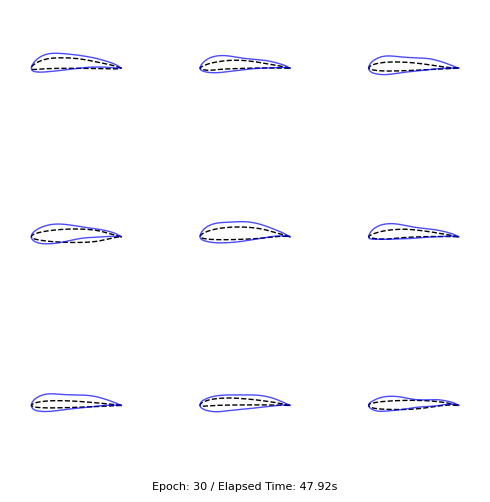

Epoch 31/1000: 100%|██████████| 48/48 [00:01<00:00, 27.46it/s]


Epoch 31/1000, Time: 49.75s, Total Loss: 0.0178, Reco Loss: 0.0170, KL Loss: 5.0550
Generating and plotting airfoils...


Epoch 32/1000: 100%|██████████| 48/48 [00:01<00:00, 28.72it/s]


Epoch 32/1000, Time: 51.45s, Total Loss: 0.0175, Reco Loss: 0.0167, KL Loss: 5.0168
Generating and plotting airfoils...


Epoch 33/1000: 100%|██████████| 48/48 [00:01<00:00, 28.89it/s]


Epoch 33/1000, Time: 53.15s, Total Loss: 0.0154, Reco Loss: 0.0146, KL Loss: 5.0118
Generating and plotting airfoils...


Epoch 34/1000: 100%|██████████| 48/48 [00:01<00:00, 29.27it/s]


Epoch 34/1000, Time: 54.82s, Total Loss: 0.0140, Reco Loss: 0.0131, KL Loss: 5.0399
Generating and plotting airfoils...


Epoch 35/1000: 100%|██████████| 48/48 [00:01<00:00, 28.79it/s]


Epoch 35/1000, Time: 56.52s, Total Loss: 0.0133, Reco Loss: 0.0125, KL Loss: 5.0890
Generating and plotting airfoils...


Epoch 36/1000: 100%|██████████| 48/48 [00:01<00:00, 28.70it/s]


Epoch 36/1000, Time: 58.23s, Total Loss: 0.0139, Reco Loss: 0.0130, KL Loss: 5.1018
Generating and plotting airfoils...


Epoch 37/1000: 100%|██████████| 48/48 [00:01<00:00, 28.85it/s]


Epoch 37/1000, Time: 59.92s, Total Loss: 0.0130, Reco Loss: 0.0121, KL Loss: 5.0836
Generating and plotting airfoils...


Epoch 38/1000: 100%|██████████| 48/48 [00:01<00:00, 28.87it/s]


Epoch 38/1000, Time: 61.62s, Total Loss: 0.0146, Reco Loss: 0.0137, KL Loss: 5.0635
Generating and plotting airfoils...


Epoch 39/1000: 100%|██████████| 48/48 [00:01<00:00, 28.69it/s]


Epoch 39/1000, Time: 63.33s, Total Loss: 0.0155, Reco Loss: 0.0146, KL Loss: 5.0435
Generating and plotting airfoils...


Epoch 40/1000: 100%|██████████| 48/48 [00:01<00:00, 25.63it/s]

Epoch 40/1000, Time: 65.23s, Total Loss: 0.0149, Reco Loss: 0.0139, KL Loss: 4.9915
Generating and plotting airfoils...


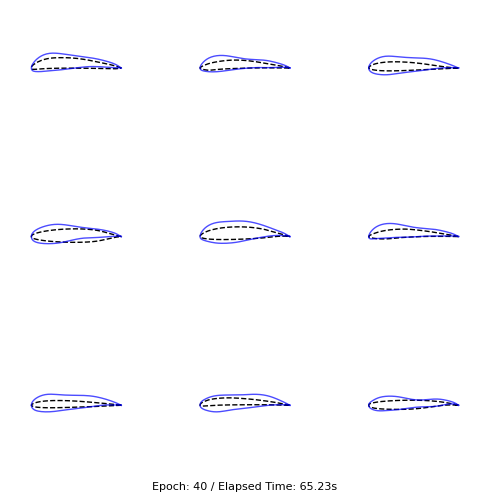

Epoch 41/1000: 100%|██████████| 48/48 [00:01<00:00, 24.90it/s]


Epoch 41/1000, Time: 67.25s, Total Loss: 0.0134, Reco Loss: 0.0124, KL Loss: 4.9885
Generating and plotting airfoils...


Epoch 42/1000: 100%|██████████| 48/48 [00:01<00:00, 25.77it/s]


Epoch 42/1000, Time: 69.16s, Total Loss: 0.0130, Reco Loss: 0.0120, KL Loss: 4.9905
Generating and plotting airfoils...


Epoch 43/1000: 100%|██████████| 48/48 [00:01<00:00, 25.73it/s]


Epoch 43/1000, Time: 71.06s, Total Loss: 0.0123, Reco Loss: 0.0112, KL Loss: 4.9905
Generating and plotting airfoils...


Epoch 44/1000: 100%|██████████| 48/48 [00:01<00:00, 26.62it/s]


Epoch 44/1000, Time: 72.90s, Total Loss: 0.0118, Reco Loss: 0.0107, KL Loss: 4.9933
Generating and plotting airfoils...


Epoch 45/1000: 100%|██████████| 48/48 [00:00<00:00, 512.29it/s]


Epoch 45/1000, Time: 73.03s, Total Loss: 0.0128, Reco Loss: 0.0117, KL Loss: 4.9673
Generating and plotting airfoils...


Epoch 46/1000: 100%|██████████| 48/48 [00:01<00:00, 28.40it/s]


Epoch 46/1000, Time: 74.75s, Total Loss: 0.0141, Reco Loss: 0.0130, KL Loss: 4.9237
Generating and plotting airfoils...


Epoch 47/1000: 100%|██████████| 48/48 [00:01<00:00, 27.04it/s]


Epoch 47/1000, Time: 76.56s, Total Loss: 0.0136, Reco Loss: 0.0124, KL Loss: 4.9046
Generating and plotting airfoils...


Epoch 48/1000: 100%|██████████| 48/48 [00:01<00:00, 27.30it/s]


Epoch 48/1000, Time: 78.36s, Total Loss: 0.0132, Reco Loss: 0.0120, KL Loss: 4.8980
Generating and plotting airfoils...


Epoch 49/1000: 100%|██████████| 48/48 [00:01<00:00, 25.81it/s]


Epoch 49/1000, Time: 80.26s, Total Loss: 0.0120, Reco Loss: 0.0108, KL Loss: 4.8853
Generating and plotting airfoils...


Epoch 50/1000: 100%|██████████| 48/48 [00:01<00:00, 28.46it/s]

Epoch 50/1000, Time: 81.98s, Total Loss: 0.0120, Reco Loss: 0.0108, KL Loss: 4.9050
Generating and plotting airfoils...


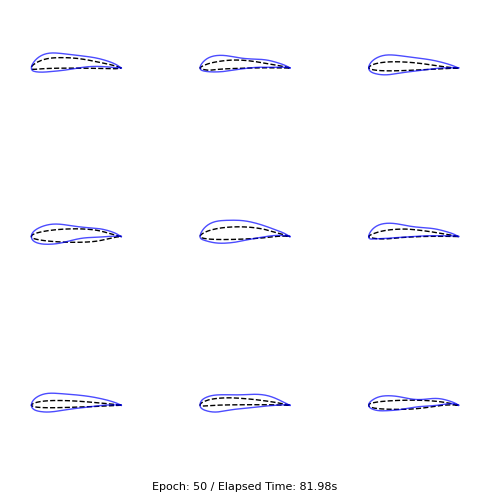

Epoch 51/1000: 100%|██████████| 48/48 [00:01<00:00, 25.29it/s]


Epoch 51/1000, Time: 83.97s, Total Loss: 0.0120, Reco Loss: 0.0108, KL Loss: 4.9178
Generating and plotting airfoils...


Epoch 52/1000: 100%|██████████| 48/48 [00:01<00:00, 26.65it/s]


Epoch 52/1000, Time: 85.81s, Total Loss: 0.0134, Reco Loss: 0.0121, KL Loss: 4.8912
Generating and plotting airfoils...


Epoch 53/1000: 100%|██████████| 48/48 [00:01<00:00, 28.31it/s]


Epoch 53/1000, Time: 87.54s, Total Loss: 0.0142, Reco Loss: 0.0130, KL Loss: 4.8613
Generating and plotting airfoils...


Epoch 54/1000: 100%|██████████| 48/48 [00:01<00:00, 29.05it/s]


Epoch 54/1000, Time: 89.22s, Total Loss: 0.0130, Reco Loss: 0.0117, KL Loss: 4.8303
Generating and plotting airfoils...


Epoch 55/1000: 100%|██████████| 48/48 [00:01<00:00, 29.19it/s]


Epoch 55/1000, Time: 90.90s, Total Loss: 0.0152, Reco Loss: 0.0139, KL Loss: 4.7826
Generating and plotting airfoils...


Epoch 56/1000: 100%|██████████| 48/48 [00:01<00:00, 28.29it/s]


Epoch 56/1000, Time: 92.63s, Total Loss: 0.0134, Reco Loss: 0.0121, KL Loss: 4.7514
Generating and plotting airfoils...


Epoch 57/1000: 100%|██████████| 48/48 [00:01<00:00, 28.21it/s]


Epoch 57/1000, Time: 94.37s, Total Loss: 0.0135, Reco Loss: 0.0122, KL Loss: 4.7569
Generating and plotting airfoils...


Epoch 58/1000: 100%|██████████| 48/48 [00:01<00:00, 29.04it/s]


Epoch 58/1000, Time: 96.05s, Total Loss: 0.0118, Reco Loss: 0.0104, KL Loss: 4.8138
Generating and plotting airfoils...


Epoch 59/1000: 100%|██████████| 48/48 [00:01<00:00, 28.68it/s]


Epoch 59/1000, Time: 97.76s, Total Loss: 0.0115, Reco Loss: 0.0101, KL Loss: 4.8232
Generating and plotting airfoils...


Epoch 60/1000: 100%|██████████| 48/48 [00:01<00:00, 29.03it/s]

Epoch 60/1000, Time: 99.44s, Total Loss: 0.0108, Reco Loss: 0.0094, KL Loss: 4.8414
Generating and plotting airfoils...


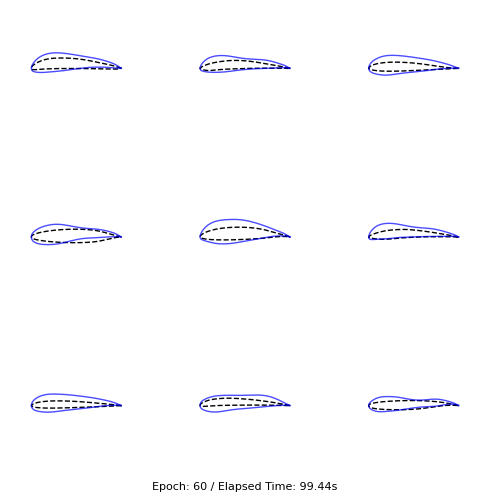

Epoch 61/1000: 100%|██████████| 48/48 [00:01<00:00, 28.02it/s]


Epoch 61/1000, Time: 101.25s, Total Loss: 0.0101, Reco Loss: 0.0087, KL Loss: 4.8583
Generating and plotting airfoils...


Epoch 62/1000: 100%|██████████| 48/48 [00:01<00:00, 27.95it/s]


Epoch 62/1000, Time: 103.00s, Total Loss: 0.0098, Reco Loss: 0.0083, KL Loss: 4.8758
Generating and plotting airfoils...


Epoch 63/1000: 100%|██████████| 48/48 [00:01<00:00, 29.26it/s]


Epoch 63/1000, Time: 104.67s, Total Loss: 0.0100, Reco Loss: 0.0085, KL Loss: 4.8613
Generating and plotting airfoils...


Epoch 64/1000: 100%|██████████| 48/48 [00:00<00:00, -71.44it/s]


Epoch 64/1000, Time: 104.03s, Total Loss: 0.0099, Reco Loss: 0.0084, KL Loss: 4.8407
Generating and plotting airfoils...


Epoch 65/1000: 100%|██████████| 48/48 [00:01<00:00, 28.31it/s]


Epoch 65/1000, Time: 105.77s, Total Loss: 0.0102, Reco Loss: 0.0087, KL Loss: 4.8546
Generating and plotting airfoils...


Epoch 66/1000: 100%|██████████| 48/48 [00:01<00:00, 29.35it/s]


Epoch 66/1000, Time: 107.44s, Total Loss: 0.0113, Reco Loss: 0.0097, KL Loss: 4.8456
Generating and plotting airfoils...


Epoch 67/1000: 100%|██████████| 48/48 [00:01<00:00, 28.82it/s]


Epoch 67/1000, Time: 109.13s, Total Loss: 0.0107, Reco Loss: 0.0091, KL Loss: 4.7906
Generating and plotting airfoils...


Epoch 68/1000: 100%|██████████| 48/48 [00:01<00:00, 28.51it/s]


Epoch 68/1000, Time: 110.85s, Total Loss: 0.0102, Reco Loss: 0.0086, KL Loss: 4.7860
Generating and plotting airfoils...


Epoch 69/1000: 100%|██████████| 48/48 [00:02<00:00, 18.53it/s]


Epoch 69/1000, Time: 113.47s, Total Loss: 0.0120, Reco Loss: 0.0104, KL Loss: 4.7544
Generating and plotting airfoils...


Epoch 70/1000: 100%|██████████| 48/48 [00:01<00:00, 27.65it/s]

Epoch 70/1000, Time: 115.24s, Total Loss: 0.0135, Reco Loss: 0.0118, KL Loss: 4.7349
Generating and plotting airfoils...


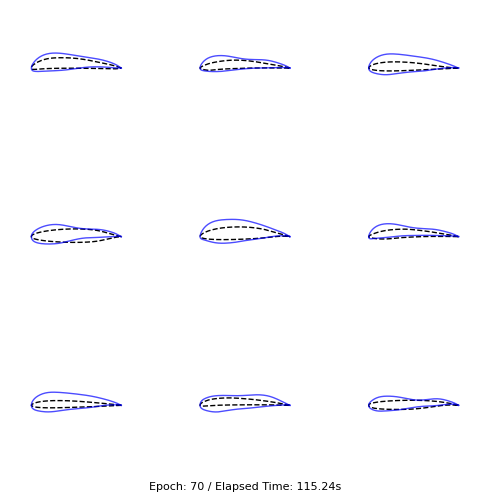

Epoch 71/1000: 100%|██████████| 48/48 [00:01<00:00, 27.42it/s]


Epoch 71/1000, Time: 117.08s, Total Loss: 0.0116, Reco Loss: 0.0100, KL Loss: 4.7291
Generating and plotting airfoils...


Epoch 72/1000: 100%|██████████| 48/48 [00:01<00:00, 28.93it/s]


Epoch 72/1000, Time: 118.77s, Total Loss: 0.0114, Reco Loss: 0.0097, KL Loss: 4.7368
Generating and plotting airfoils...


Epoch 73/1000: 100%|██████████| 48/48 [00:01<00:00, 28.86it/s]


Epoch 73/1000, Time: 120.46s, Total Loss: 0.0112, Reco Loss: 0.0095, KL Loss: 4.7213
Generating and plotting airfoils...


Epoch 74/1000: 100%|██████████| 48/48 [00:01<00:00, 28.09it/s]


Epoch 74/1000, Time: 122.21s, Total Loss: 0.0121, Reco Loss: 0.0103, KL Loss: 4.7120
Generating and plotting airfoils...


Epoch 75/1000: 100%|██████████| 48/48 [00:01<00:00, 27.91it/s]


Epoch 75/1000, Time: 123.96s, Total Loss: 0.0132, Reco Loss: 0.0114, KL Loss: 4.6721
Generating and plotting airfoils...


Epoch 76/1000: 100%|██████████| 48/48 [00:01<00:00, 27.55it/s]


Epoch 76/1000, Time: 125.73s, Total Loss: 0.0119, Reco Loss: 0.0102, KL Loss: 4.6978
Generating and plotting airfoils...


Epoch 77/1000: 100%|██████████| 48/48 [00:01<00:00, 29.01it/s]


Epoch 77/1000, Time: 127.42s, Total Loss: 0.0102, Reco Loss: 0.0084, KL Loss: 4.7214
Generating and plotting airfoils...


Epoch 78/1000: 100%|██████████| 48/48 [00:01<00:00, 28.95it/s]


Epoch 78/1000, Time: 129.11s, Total Loss: 0.0092, Reco Loss: 0.0073, KL Loss: 4.7268
Generating and plotting airfoils...


Epoch 79/1000: 100%|██████████| 48/48 [00:01<00:00, 28.68it/s]


Epoch 79/1000, Time: 130.82s, Total Loss: 0.0098, Reco Loss: 0.0080, KL Loss: 4.7020
Generating and plotting airfoils...


Epoch 80/1000: 100%|██████████| 48/48 [00:01<00:00, 28.82it/s]

Epoch 80/1000, Time: 132.52s, Total Loss: 0.0087, Reco Loss: 0.0068, KL Loss: 4.7013
Generating and plotting airfoils...


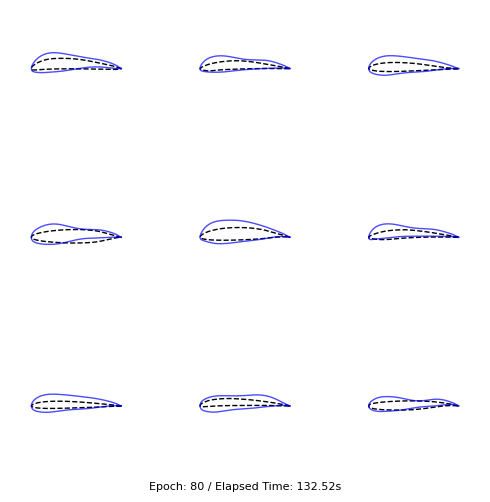

Epoch 81/1000: 100%|██████████| 48/48 [00:01<00:00, 27.38it/s]


Epoch 81/1000, Time: 134.36s, Total Loss: 0.0094, Reco Loss: 0.0075, KL Loss: 4.6994
Generating and plotting airfoils...


Epoch 82/1000: 100%|██████████| 48/48 [00:00<00:00, -57.87it/s]


Epoch 82/1000, Time: 133.56s, Total Loss: 0.0098, Reco Loss: 0.0079, KL Loss: 4.6611
Generating and plotting airfoils...


Epoch 83/1000: 100%|██████████| 48/48 [00:01<00:00, 29.02it/s]


Epoch 83/1000, Time: 135.25s, Total Loss: 0.0100, Reco Loss: 0.0081, KL Loss: 4.6727
Generating and plotting airfoils...


Epoch 84/1000: 100%|██████████| 48/48 [00:01<00:00, 29.08it/s]


Epoch 84/1000, Time: 136.93s, Total Loss: 0.0102, Reco Loss: 0.0083, KL Loss: 4.6652
Generating and plotting airfoils...


Epoch 85/1000: 100%|██████████| 48/48 [00:01<00:00, 29.14it/s]


Epoch 85/1000, Time: 138.61s, Total Loss: 0.0124, Reco Loss: 0.0104, KL Loss: 4.6441
Generating and plotting airfoils...


Epoch 86/1000: 100%|██████████| 48/48 [00:01<00:00, 28.93it/s]


Epoch 86/1000, Time: 140.30s, Total Loss: 0.0153, Reco Loss: 0.0133, KL Loss: 4.5984
Generating and plotting airfoils...


Epoch 87/1000: 100%|██████████| 48/48 [00:01<00:00, 28.47it/s]


Epoch 87/1000, Time: 142.02s, Total Loss: 0.0115, Reco Loss: 0.0095, KL Loss: 4.5764
Generating and plotting airfoils...


Epoch 88/1000: 100%|██████████| 48/48 [00:01<00:00, 28.84it/s]


Epoch 88/1000, Time: 143.72s, Total Loss: 0.0112, Reco Loss: 0.0092, KL Loss: 4.6141
Generating and plotting airfoils...


Epoch 89/1000: 100%|██████████| 48/48 [00:01<00:00, 26.35it/s]


Epoch 89/1000, Time: 145.58s, Total Loss: 0.0121, Reco Loss: 0.0101, KL Loss: 4.5996
Generating and plotting airfoils...


Epoch 90/1000: 100%|██████████| 48/48 [00:01<00:00, 28.28it/s]

Epoch 90/1000, Time: 147.31s, Total Loss: 0.0112, Reco Loss: 0.0091, KL Loss: 4.6188
Generating and plotting airfoils...


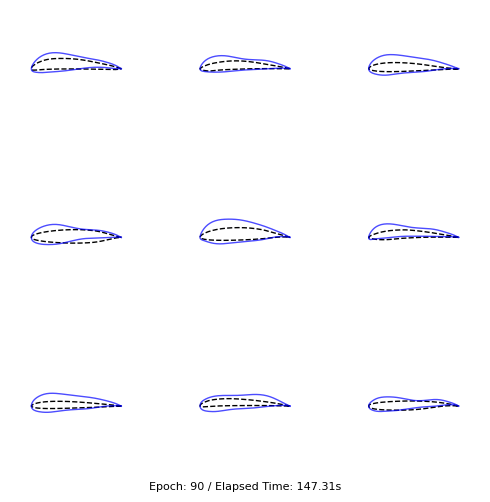

Epoch 91/1000: 100%|██████████| 48/48 [00:01<00:00, 27.03it/s]


Epoch 91/1000, Time: 149.17s, Total Loss: 0.0103, Reco Loss: 0.0082, KL Loss: 4.6358
Generating and plotting airfoils...


Epoch 92/1000: 100%|██████████| 48/48 [00:01<00:00, 29.28it/s]


Epoch 92/1000, Time: 150.84s, Total Loss: 0.0102, Reco Loss: 0.0081, KL Loss: 4.6129
Generating and plotting airfoils...


Epoch 93/1000: 100%|██████████| 48/48 [00:01<00:00, 28.42it/s]


Epoch 93/1000, Time: 152.56s, Total Loss: 0.0099, Reco Loss: 0.0078, KL Loss: 4.6302
Generating and plotting airfoils...


Epoch 94/1000: 100%|██████████| 48/48 [00:01<00:00, 28.92it/s]


Epoch 94/1000, Time: 154.25s, Total Loss: 0.0109, Reco Loss: 0.0088, KL Loss: 4.6092
Generating and plotting airfoils...


Epoch 95/1000: 100%|██████████| 48/48 [00:01<00:00, 27.91it/s]


Epoch 95/1000, Time: 156.01s, Total Loss: 0.0107, Reco Loss: 0.0086, KL Loss: 4.5822
Generating and plotting airfoils...


Epoch 96/1000: 100%|██████████| 48/48 [00:01<00:00, 29.35it/s]


Epoch 96/1000, Time: 157.67s, Total Loss: 0.0116, Reco Loss: 0.0094, KL Loss: 4.5856
Generating and plotting airfoils...


Epoch 97/1000: 100%|██████████| 48/48 [00:01<00:00, 28.26it/s]


Epoch 97/1000, Time: 159.41s, Total Loss: 0.0125, Reco Loss: 0.0104, KL Loss: 4.5332
Generating and plotting airfoils...


Epoch 98/1000: 100%|██████████| 48/48 [00:01<00:00, 28.04it/s]


Epoch 98/1000, Time: 161.15s, Total Loss: 0.0122, Reco Loss: 0.0100, KL Loss: 4.5223
Generating and plotting airfoils...


Epoch 99/1000: 100%|██████████| 48/48 [00:02<00:00, 16.71it/s]


Epoch 99/1000, Time: 164.06s, Total Loss: 0.0123, Reco Loss: 0.0101, KL Loss: 4.5134
Generating and plotting airfoils...


Epoch 100/1000: 100%|██████████| 48/48 [00:00<00:00, -63.31it/s]

Epoch 100/1000, Time: 163.33s, Total Loss: 0.0117, Reco Loss: 0.0095, KL Loss: 4.5523
Generating and plotting airfoils...


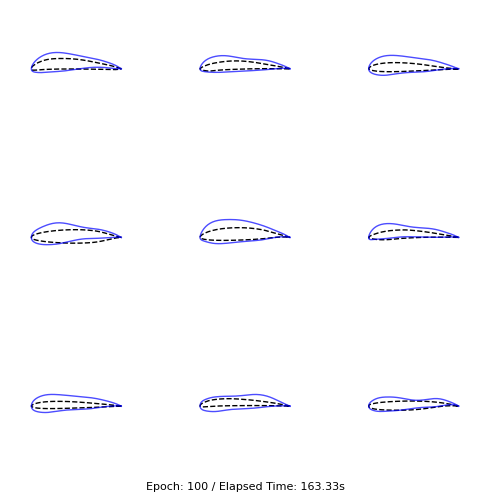

Epoch 101/1000: 100%|██████████| 48/48 [00:01<00:00, 26.99it/s]


Epoch 101/1000, Time: 165.20s, Total Loss: 0.0118, Reco Loss: 0.0095, KL Loss: 4.5328
Generating and plotting airfoils...


Epoch 102/1000: 100%|██████████| 48/48 [00:01<00:00, 28.74it/s]


Epoch 102/1000, Time: 166.90s, Total Loss: 0.0116, Reco Loss: 0.0093, KL Loss: 4.5410
Generating and plotting airfoils...


Epoch 103/1000: 100%|██████████| 48/48 [00:01<00:00, 29.38it/s]


Epoch 103/1000, Time: 168.57s, Total Loss: 0.0112, Reco Loss: 0.0089, KL Loss: 4.5452
Generating and plotting airfoils...


Epoch 104/1000: 100%|██████████| 48/48 [00:01<00:00, 28.63it/s]


Epoch 104/1000, Time: 170.28s, Total Loss: 0.0092, Reco Loss: 0.0068, KL Loss: 4.5641
Generating and plotting airfoils...


Epoch 105/1000: 100%|██████████| 48/48 [00:01<00:00, 28.54it/s]


Epoch 105/1000, Time: 171.99s, Total Loss: 0.0096, Reco Loss: 0.0073, KL Loss: 4.5439
Generating and plotting airfoils...


Epoch 106/1000: 100%|██████████| 48/48 [00:01<00:00, 27.10it/s]


Epoch 106/1000, Time: 173.79s, Total Loss: 0.0090, Reco Loss: 0.0067, KL Loss: 4.5568
Generating and plotting airfoils...


Epoch 107/1000: 100%|██████████| 48/48 [00:01<00:00, 27.05it/s]


Epoch 107/1000, Time: 175.60s, Total Loss: 0.0107, Reco Loss: 0.0083, KL Loss: 4.5499
Generating and plotting airfoils...


Epoch 108/1000: 100%|██████████| 48/48 [00:01<00:00, 28.44it/s]


Epoch 108/1000, Time: 177.32s, Total Loss: 0.0118, Reco Loss: 0.0094, KL Loss: 4.4930
Generating and plotting airfoils...


Epoch 109/1000: 100%|██████████| 48/48 [00:01<00:00, 29.28it/s]


Epoch 109/1000, Time: 178.99s, Total Loss: 0.0118, Reco Loss: 0.0094, KL Loss: 4.5132
Generating and plotting airfoils...


Epoch 110/1000: 100%|██████████| 48/48 [00:01<00:00, 27.88it/s]

Epoch 110/1000, Time: 180.75s, Total Loss: 0.0123, Reco Loss: 0.0099, KL Loss: 4.5146
Generating and plotting airfoils...


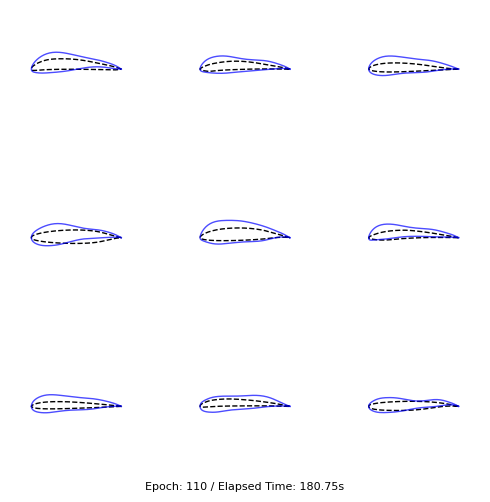

Epoch 111/1000: 100%|██████████| 48/48 [00:01<00:00, 28.12it/s]


Epoch 111/1000, Time: 182.54s, Total Loss: 0.0120, Reco Loss: 0.0095, KL Loss: 4.5022
Generating and plotting airfoils...


Epoch 112/1000: 100%|██████████| 48/48 [00:01<00:00, 28.70it/s]


Epoch 112/1000, Time: 184.25s, Total Loss: 0.0102, Reco Loss: 0.0077, KL Loss: 4.4981
Generating and plotting airfoils...


Epoch 113/1000: 100%|██████████| 48/48 [00:01<00:00, 26.00it/s]


Epoch 113/1000, Time: 186.13s, Total Loss: 0.0093, Reco Loss: 0.0067, KL Loss: 4.5198
Generating and plotting airfoils...


Epoch 114/1000: 100%|██████████| 48/48 [00:01<00:00, 28.41it/s]


Epoch 114/1000, Time: 187.85s, Total Loss: 0.0096, Reco Loss: 0.0071, KL Loss: 4.5021
Generating and plotting airfoils...


Epoch 115/1000: 100%|██████████| 48/48 [00:01<00:00, 27.39it/s]


Epoch 115/1000, Time: 189.64s, Total Loss: 0.0095, Reco Loss: 0.0069, KL Loss: 4.5050
Generating and plotting airfoils...


Epoch 116/1000: 100%|██████████| 48/48 [00:01<00:00, 28.70it/s]


Epoch 116/1000, Time: 191.34s, Total Loss: 0.0104, Reco Loss: 0.0078, KL Loss: 4.4838
Generating and plotting airfoils...


Epoch 117/1000: 100%|██████████| 48/48 [00:01<00:00, 28.70it/s]


Epoch 117/1000, Time: 193.05s, Total Loss: 0.0111, Reco Loss: 0.0086, KL Loss: 4.4324
Generating and plotting airfoils...


Epoch 118/1000: 100%|██████████| 48/48 [00:01<00:00, 28.76it/s]


Epoch 118/1000, Time: 194.75s, Total Loss: 0.0112, Reco Loss: 0.0086, KL Loss: 4.4361
Generating and plotting airfoils...


Epoch 119/1000: 100%|██████████| 48/48 [00:00<00:00, -71.63it/s]


Epoch 119/1000, Time: 194.11s, Total Loss: 0.0132, Reco Loss: 0.0106, KL Loss: 4.4210
Generating and plotting airfoils...


Epoch 120/1000: 100%|██████████| 48/48 [00:01<00:00, 28.06it/s]

Epoch 120/1000, Time: 195.86s, Total Loss: 0.0129, Reco Loss: 0.0103, KL Loss: 4.4447
Generating and plotting airfoils...


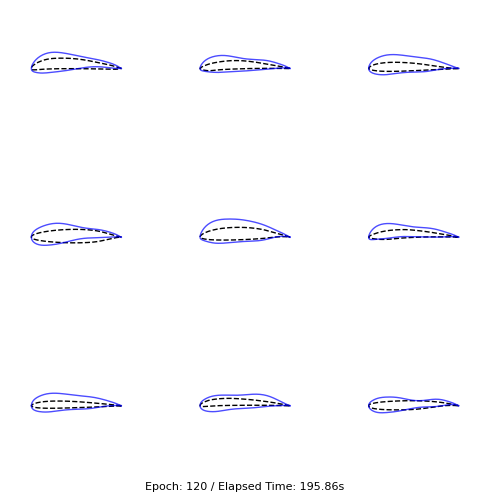

Epoch 121/1000: 100%|██████████| 48/48 [00:01<00:00, 27.21it/s]


Epoch 121/1000, Time: 197.71s, Total Loss: 0.0126, Reco Loss: 0.0099, KL Loss: 4.4392
Generating and plotting airfoils...


Epoch 122/1000: 100%|██████████| 48/48 [00:01<00:00, 27.55it/s]


Epoch 122/1000, Time: 199.48s, Total Loss: 0.0102, Reco Loss: 0.0075, KL Loss: 4.4668
Generating and plotting airfoils...


Epoch 123/1000: 100%|██████████| 48/48 [00:01<00:00, 27.88it/s]


Epoch 123/1000, Time: 201.24s, Total Loss: 0.0097, Reco Loss: 0.0070, KL Loss: 4.4719
Generating and plotting airfoils...


Epoch 124/1000: 100%|██████████| 48/48 [00:01<00:00, 27.76it/s]


Epoch 124/1000, Time: 203.00s, Total Loss: 0.0108, Reco Loss: 0.0081, KL Loss: 4.4081
Generating and plotting airfoils...


Epoch 125/1000: 100%|██████████| 48/48 [00:01<00:00, 27.76it/s]


Epoch 125/1000, Time: 204.76s, Total Loss: 0.0110, Reco Loss: 0.0083, KL Loss: 4.4168
Generating and plotting airfoils...


Epoch 126/1000: 100%|██████████| 48/48 [00:01<00:00, 27.13it/s]


Epoch 126/1000, Time: 206.58s, Total Loss: 0.0101, Reco Loss: 0.0073, KL Loss: 4.4319
Generating and plotting airfoils...


Epoch 127/1000: 100%|██████████| 48/48 [00:01<00:00, 27.73it/s]


Epoch 127/1000, Time: 208.34s, Total Loss: 0.0120, Reco Loss: 0.0092, KL Loss: 4.4048
Generating and plotting airfoils...


Epoch 128/1000: 100%|██████████| 48/48 [00:01<00:00, 28.14it/s]


Epoch 128/1000, Time: 210.08s, Total Loss: 0.0105, Reco Loss: 0.0077, KL Loss: 4.4121
Generating and plotting airfoils...


Epoch 129/1000: 100%|██████████| 48/48 [00:01<00:00, 27.77it/s]


Epoch 129/1000, Time: 211.84s, Total Loss: 0.0104, Reco Loss: 0.0076, KL Loss: 4.4448
Generating and plotting airfoils...


Epoch 130/1000: 100%|██████████| 48/48 [00:01<00:00, 28.12it/s]

Epoch 130/1000, Time: 213.58s, Total Loss: 0.0104, Reco Loss: 0.0076, KL Loss: 4.4198
Generating and plotting airfoils...


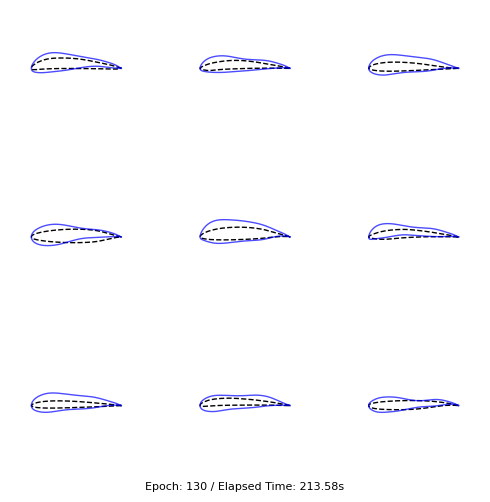

Epoch 131/1000: 100%|██████████| 48/48 [00:01<00:00, 26.03it/s]


Epoch 131/1000, Time: 215.51s, Total Loss: 0.0100, Reco Loss: 0.0072, KL Loss: 4.4053
Generating and plotting airfoils...


Epoch 132/1000: 100%|██████████| 48/48 [00:01<00:00, 26.96it/s]


Epoch 132/1000, Time: 217.32s, Total Loss: 0.0109, Reco Loss: 0.0081, KL Loss: 4.4134
Generating and plotting airfoils...


Epoch 133/1000: 100%|██████████| 48/48 [00:01<00:00, 27.89it/s]


Epoch 133/1000, Time: 219.08s, Total Loss: 0.0106, Reco Loss: 0.0077, KL Loss: 4.3879
Generating and plotting airfoils...


Epoch 134/1000: 100%|██████████| 48/48 [00:01<00:00, 27.52it/s]


Epoch 134/1000, Time: 220.86s, Total Loss: 0.0107, Reco Loss: 0.0078, KL Loss: 4.3631
Generating and plotting airfoils...


Epoch 135/1000: 100%|██████████| 48/48 [00:03<00:00, 14.74it/s]


Epoch 135/1000, Time: 224.14s, Total Loss: 0.0113, Reco Loss: 0.0083, KL Loss: 4.3798
Generating and plotting airfoils...


Epoch 136/1000: 100%|██████████| 48/48 [00:00<00:00, -63.91it/s]


Epoch 136/1000, Time: 223.42s, Total Loss: 0.0111, Reco Loss: 0.0082, KL Loss: 4.3822
Generating and plotting airfoils...


Epoch 137/1000: 100%|██████████| 48/48 [00:01<00:00, 26.21it/s]


Epoch 137/1000, Time: 225.29s, Total Loss: 0.0107, Reco Loss: 0.0077, KL Loss: 4.3780
Generating and plotting airfoils...


Epoch 138/1000: 100%|██████████| 48/48 [00:01<00:00, 27.57it/s]


Epoch 138/1000, Time: 227.07s, Total Loss: 0.0105, Reco Loss: 0.0075, KL Loss: 4.3743
Generating and plotting airfoils...


Epoch 139/1000: 100%|██████████| 48/48 [00:01<00:00, 27.45it/s]


Epoch 139/1000, Time: 228.85s, Total Loss: 0.0124, Reco Loss: 0.0094, KL Loss: 4.3367
Generating and plotting airfoils...


Epoch 140/1000: 100%|██████████| 48/48 [00:01<00:00, 27.96it/s]

Epoch 140/1000, Time: 230.60s, Total Loss: 0.0101, Reco Loss: 0.0071, KL Loss: 4.3517
Generating and plotting airfoils...


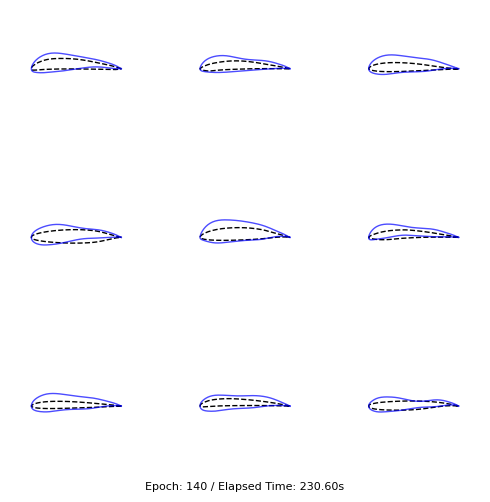

Epoch 141/1000: 100%|██████████| 48/48 [00:01<00:00, 27.13it/s]


Epoch 141/1000, Time: 232.45s, Total Loss: 0.0096, Reco Loss: 0.0065, KL Loss: 4.3703
Generating and plotting airfoils...


Epoch 142/1000: 100%|██████████| 48/48 [00:01<00:00, 27.71it/s]


Epoch 142/1000, Time: 234.21s, Total Loss: 0.0101, Reco Loss: 0.0070, KL Loss: 4.3321
Generating and plotting airfoils...


Epoch 143/1000: 100%|██████████| 48/48 [00:01<00:00, 27.34it/s]


Epoch 143/1000, Time: 236.00s, Total Loss: 0.0108, Reco Loss: 0.0078, KL Loss: 4.3073
Generating and plotting airfoils...


Epoch 144/1000: 100%|██████████| 48/48 [00:01<00:00, 28.85it/s]


Epoch 144/1000, Time: 237.69s, Total Loss: 0.0095, Reco Loss: 0.0064, KL Loss: 4.3726
Generating and plotting airfoils...


Epoch 145/1000: 100%|██████████| 48/48 [00:01<00:00, 28.55it/s]


Epoch 145/1000, Time: 239.41s, Total Loss: 0.0109, Reco Loss: 0.0078, KL Loss: 4.3290
Generating and plotting airfoils...


Epoch 146/1000: 100%|██████████| 48/48 [00:01<00:00, 28.02it/s]


Epoch 146/1000, Time: 241.15s, Total Loss: 0.0111, Reco Loss: 0.0079, KL Loss: 4.3354
Generating and plotting airfoils...


Epoch 147/1000: 100%|██████████| 48/48 [00:01<00:00, 28.70it/s]


Epoch 147/1000, Time: 242.86s, Total Loss: 0.0109, Reco Loss: 0.0077, KL Loss: 4.3390
Generating and plotting airfoils...


Epoch 148/1000: 100%|██████████| 48/48 [00:01<00:00, 28.21it/s]


Epoch 148/1000, Time: 244.59s, Total Loss: 0.0103, Reco Loss: 0.0071, KL Loss: 4.3153
Generating and plotting airfoils...


Epoch 149/1000: 100%|██████████| 48/48 [00:01<00:00, 26.92it/s]


Epoch 149/1000, Time: 246.41s, Total Loss: 0.0098, Reco Loss: 0.0066, KL Loss: 4.3255
Generating and plotting airfoils...


Epoch 150/1000: 100%|██████████| 48/48 [00:01<00:00, 26.01it/s]

Epoch 150/1000, Time: 248.29s, Total Loss: 0.0122, Reco Loss: 0.0090, KL Loss: 4.3280
Generating and plotting airfoils...


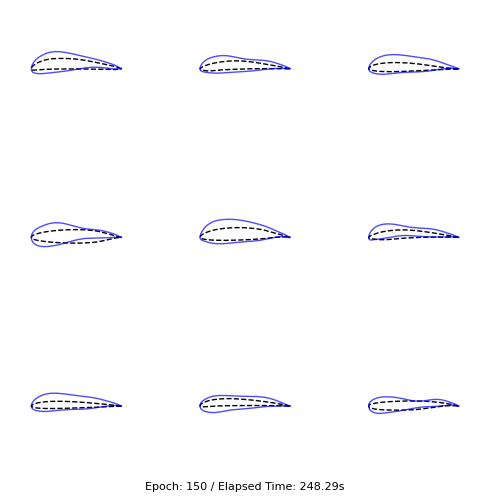

Epoch 151/1000: 100%|██████████| 48/48 [00:01<00:00, 25.42it/s]


Epoch 151/1000, Time: 250.26s, Total Loss: 0.0133, Reco Loss: 0.0101, KL Loss: 4.2764
Generating and plotting airfoils...


Epoch 152/1000: 100%|██████████| 48/48 [00:01<00:00, 27.83it/s]


Epoch 152/1000, Time: 252.02s, Total Loss: 0.0117, Reco Loss: 0.0084, KL Loss: 4.2996
Generating and plotting airfoils...


Epoch 153/1000: 100%|██████████| 48/48 [00:01<00:00, 28.73it/s]


Epoch 153/1000, Time: 253.72s, Total Loss: 0.0100, Reco Loss: 0.0068, KL Loss: 4.3222
Generating and plotting airfoils...


Epoch 154/1000: 100%|██████████| 48/48 [00:00<00:00, -58.00it/s]


Epoch 154/1000, Time: 252.92s, Total Loss: 0.0090, Reco Loss: 0.0057, KL Loss: 4.3036
Generating and plotting airfoils...


Epoch 155/1000: 100%|██████████| 48/48 [00:01<00:00, 28.11it/s]


Epoch 155/1000, Time: 254.66s, Total Loss: 0.0096, Reco Loss: 0.0063, KL Loss: 4.2888
Generating and plotting airfoils...


Epoch 156/1000: 100%|██████████| 48/48 [00:01<00:00, 25.52it/s]


Epoch 156/1000, Time: 256.58s, Total Loss: 0.0102, Reco Loss: 0.0068, KL Loss: 4.2755
Generating and plotting airfoils...


Epoch 157/1000: 100%|██████████| 48/48 [00:01<00:00, 24.92it/s]


Epoch 157/1000, Time: 258.55s, Total Loss: 0.0120, Reco Loss: 0.0086, KL Loss: 4.2656
Generating and plotting airfoils...


Epoch 158/1000: 100%|██████████| 48/48 [00:01<00:00, 27.97it/s]


Epoch 158/1000, Time: 260.30s, Total Loss: 0.0155, Reco Loss: 0.0121, KL Loss: 4.2674
Generating and plotting airfoils...


Epoch 159/1000: 100%|██████████| 48/48 [00:01<00:00, 27.94it/s]


Epoch 159/1000, Time: 262.05s, Total Loss: 0.0123, Reco Loss: 0.0088, KL Loss: 4.3167
Generating and plotting airfoils...


Epoch 160/1000: 100%|██████████| 48/48 [00:01<00:00, 25.80it/s]

Epoch 160/1000, Time: 263.95s, Total Loss: 0.0108, Reco Loss: 0.0074, KL Loss: 4.2771
Generating and plotting airfoils...


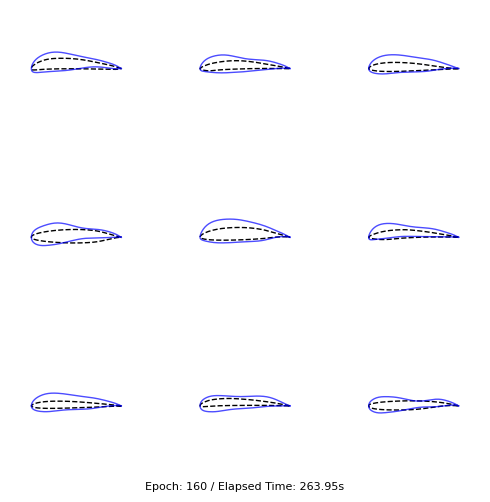

Epoch 161/1000: 100%|██████████| 48/48 [00:01<00:00, 24.41it/s]


Epoch 161/1000, Time: 266.02s, Total Loss: 0.0101, Reco Loss: 0.0067, KL Loss: 4.2759
Generating and plotting airfoils...


Epoch 162/1000: 100%|██████████| 48/48 [00:01<00:00, 24.60it/s]


Epoch 162/1000, Time: 268.01s, Total Loss: 0.0106, Reco Loss: 0.0071, KL Loss: 4.2752
Generating and plotting airfoils...


Epoch 163/1000: 100%|██████████| 48/48 [00:01<00:00, 25.46it/s]


Epoch 163/1000, Time: 269.93s, Total Loss: 0.0102, Reco Loss: 0.0068, KL Loss: 4.2472
Generating and plotting airfoils...


Epoch 164/1000: 100%|██████████| 48/48 [00:01<00:00, 26.16it/s]


Epoch 164/1000, Time: 271.80s, Total Loss: 0.0096, Reco Loss: 0.0061, KL Loss: 4.2584
Generating and plotting airfoils...


Epoch 165/1000: 100%|██████████| 48/48 [00:01<00:00, 27.27it/s]


Epoch 165/1000, Time: 273.59s, Total Loss: 0.0101, Reco Loss: 0.0066, KL Loss: 4.2643
Generating and plotting airfoils...


Epoch 166/1000: 100%|██████████| 48/48 [00:01<00:00, 27.32it/s]


Epoch 166/1000, Time: 275.38s, Total Loss: 0.0091, Reco Loss: 0.0057, KL Loss: 4.2109
Generating and plotting airfoils...


Epoch 167/1000: 100%|██████████| 48/48 [00:01<00:00, 27.56it/s]


Epoch 167/1000, Time: 277.16s, Total Loss: 0.0089, Reco Loss: 0.0053, KL Loss: 4.2616
Generating and plotting airfoils...


Epoch 168/1000: 100%|██████████| 48/48 [00:01<00:00, 27.46it/s]


Epoch 168/1000, Time: 278.94s, Total Loss: 0.0092, Reco Loss: 0.0057, KL Loss: 4.2130
Generating and plotting airfoils...


Epoch 169/1000: 100%|██████████| 48/48 [00:01<00:00, 27.27it/s]


Epoch 169/1000, Time: 280.73s, Total Loss: 0.0108, Reco Loss: 0.0072, KL Loss: 4.2089
Generating and plotting airfoils...


Epoch 170/1000: 100%|██████████| 48/48 [00:01<00:00, 27.58it/s]

Epoch 170/1000, Time: 282.50s, Total Loss: 0.0123, Reco Loss: 0.0087, KL Loss: 4.2211
Generating and plotting airfoils...


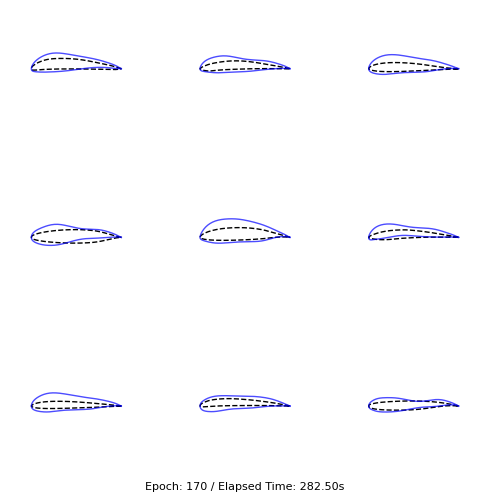

Epoch 171/1000: 100%|██████████| 48/48 [00:01<00:00, 27.11it/s]


Epoch 171/1000, Time: 284.36s, Total Loss: 0.0111, Reco Loss: 0.0075, KL Loss: 4.1846
Generating and plotting airfoils...


Epoch 172/1000: 100%|██████████| 48/48 [00:00<00:00, -60.45it/s]


Epoch 172/1000, Time: 283.60s, Total Loss: 0.0100, Reco Loss: 0.0064, KL Loss: 4.2142
Generating and plotting airfoils...


Epoch 173/1000: 100%|██████████| 48/48 [00:01<00:00, 27.20it/s]


Epoch 173/1000, Time: 285.40s, Total Loss: 0.0095, Reco Loss: 0.0059, KL Loss: 4.2049
Generating and plotting airfoils...


Epoch 174/1000: 100%|██████████| 48/48 [00:01<00:00, 26.71it/s]


Epoch 174/1000, Time: 287.23s, Total Loss: 0.0102, Reco Loss: 0.0066, KL Loss: 4.1973
Generating and plotting airfoils...


Epoch 175/1000: 100%|██████████| 48/48 [00:01<00:00, 28.05it/s]


Epoch 175/1000, Time: 288.98s, Total Loss: 0.0101, Reco Loss: 0.0064, KL Loss: 4.1879
Generating and plotting airfoils...


Epoch 176/1000: 100%|██████████| 48/48 [00:01<00:00, 26.73it/s]


Epoch 176/1000, Time: 290.81s, Total Loss: 0.0103, Reco Loss: 0.0067, KL Loss: 4.1916
Generating and plotting airfoils...


Epoch 177/1000: 100%|██████████| 48/48 [00:01<00:00, 27.98it/s]


Epoch 177/1000, Time: 292.56s, Total Loss: 0.0107, Reco Loss: 0.0070, KL Loss: 4.1872
Generating and plotting airfoils...


Epoch 178/1000: 100%|██████████| 48/48 [00:01<00:00, 27.89it/s]


Epoch 178/1000, Time: 294.31s, Total Loss: 0.0126, Reco Loss: 0.0089, KL Loss: 4.1875
Generating and plotting airfoils...


Epoch 179/1000: 100%|██████████| 48/48 [00:01<00:00, 28.21it/s]


Epoch 179/1000, Time: 296.04s, Total Loss: 0.0130, Reco Loss: 0.0093, KL Loss: 4.2045
Generating and plotting airfoils...


Epoch 180/1000: 100%|██████████| 48/48 [00:03<00:00, 12.19it/s]

Epoch 180/1000, Time: 300.01s, Total Loss: 0.0121, Reco Loss: 0.0083, KL Loss: 4.1786
Generating and plotting airfoils...


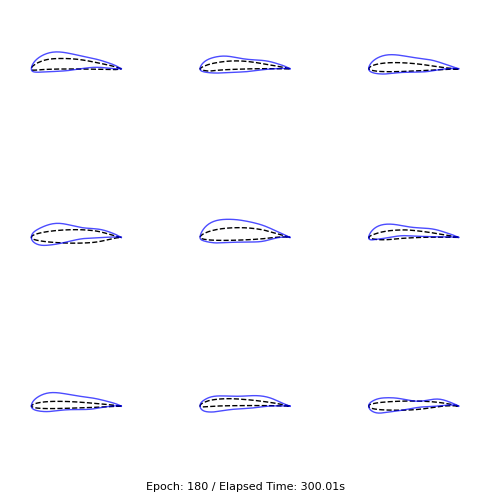

Epoch 181/1000: 100%|██████████| 48/48 [00:01<00:00, 26.66it/s]


Epoch 181/1000, Time: 301.89s, Total Loss: 0.0114, Reco Loss: 0.0076, KL Loss: 4.1654
Generating and plotting airfoils...


Epoch 182/1000: 100%|██████████| 48/48 [00:01<00:00, 28.25it/s]


Epoch 182/1000, Time: 303.63s, Total Loss: 0.0113, Reco Loss: 0.0075, KL Loss: 4.1780
Generating and plotting airfoils...


Epoch 183/1000: 100%|██████████| 48/48 [00:01<00:00, 28.53it/s]


Epoch 183/1000, Time: 305.34s, Total Loss: 0.0112, Reco Loss: 0.0075, KL Loss: 4.1643
Generating and plotting airfoils...


Epoch 184/1000: 100%|██████████| 48/48 [00:01<00:00, 27.61it/s]


Epoch 184/1000, Time: 307.11s, Total Loss: 0.0105, Reco Loss: 0.0067, KL Loss: 4.1583
Generating and plotting airfoils...


Epoch 185/1000: 100%|██████████| 48/48 [00:01<00:00, 26.69it/s]


Epoch 185/1000, Time: 308.94s, Total Loss: 0.0113, Reco Loss: 0.0075, KL Loss: 4.1062
Generating and plotting airfoils...


Epoch 186/1000: 100%|██████████| 48/48 [00:01<00:00, 27.52it/s]


Epoch 186/1000, Time: 310.72s, Total Loss: 0.0114, Reco Loss: 0.0076, KL Loss: 4.1320
Generating and plotting airfoils...


Epoch 187/1000: 100%|██████████| 48/48 [00:01<00:00, 27.71it/s]


Epoch 187/1000, Time: 312.48s, Total Loss: 0.0109, Reco Loss: 0.0070, KL Loss: 4.1472
Generating and plotting airfoils...


Epoch 188/1000: 100%|██████████| 48/48 [00:01<00:00, 28.34it/s]


Epoch 188/1000, Time: 314.21s, Total Loss: 0.0101, Reco Loss: 0.0062, KL Loss: 4.1676
Generating and plotting airfoils...


Epoch 189/1000: 100%|██████████| 48/48 [00:00<00:00, -62.71it/s]


Epoch 189/1000, Time: 313.48s, Total Loss: 0.0101, Reco Loss: 0.0062, KL Loss: 4.1627
Generating and plotting airfoils...


Epoch 190/1000: 100%|██████████| 48/48 [00:01<00:00, 28.39it/s]

Epoch 190/1000, Time: 315.20s, Total Loss: 0.0097, Reco Loss: 0.0058, KL Loss: 4.1620
Generating and plotting airfoils...


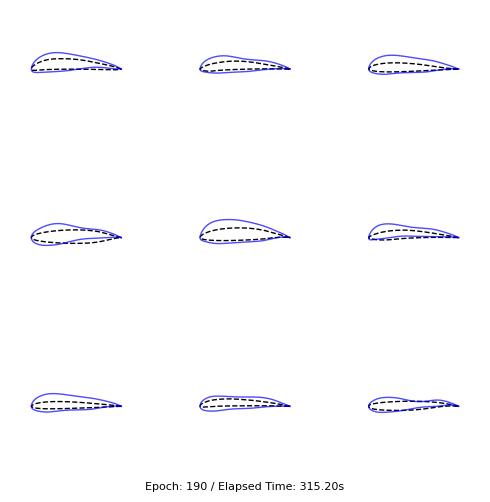

Epoch 191/1000: 100%|██████████| 48/48 [00:01<00:00, 27.01it/s]


Epoch 191/1000, Time: 317.06s, Total Loss: 0.0094, Reco Loss: 0.0054, KL Loss: 4.1396
Generating and plotting airfoils...


Epoch 192/1000: 100%|██████████| 48/48 [00:01<00:00, 27.86it/s]


Epoch 192/1000, Time: 318.81s, Total Loss: 0.0103, Reco Loss: 0.0064, KL Loss: 4.1407
Generating and plotting airfoils...


Epoch 193/1000: 100%|██████████| 48/48 [00:01<00:00, 27.75it/s]


Epoch 193/1000, Time: 320.58s, Total Loss: 0.0130, Reco Loss: 0.0091, KL Loss: 4.0969
Generating and plotting airfoils...


Epoch 194/1000: 100%|██████████| 48/48 [00:01<00:00, 27.78it/s]


Epoch 194/1000, Time: 322.34s, Total Loss: 0.0132, Reco Loss: 0.0092, KL Loss: 4.1051
Generating and plotting airfoils...


Epoch 195/1000: 100%|██████████| 48/48 [00:01<00:00, 27.95it/s]


Epoch 195/1000, Time: 324.09s, Total Loss: 0.0131, Reco Loss: 0.0091, KL Loss: 4.1231
Generating and plotting airfoils...


Epoch 196/1000: 100%|██████████| 48/48 [00:01<00:00, 27.91it/s]


Epoch 196/1000, Time: 325.84s, Total Loss: 0.0114, Reco Loss: 0.0074, KL Loss: 4.1262
Generating and plotting airfoils...


Epoch 197/1000: 100%|██████████| 48/48 [00:01<00:00, 26.15it/s]


Epoch 197/1000, Time: 327.71s, Total Loss: 0.0115, Reco Loss: 0.0075, KL Loss: 4.0726
Generating and plotting airfoils...


Epoch 198/1000: 100%|██████████| 48/48 [00:01<00:00, 27.46it/s]


Epoch 198/1000, Time: 329.49s, Total Loss: 0.0115, Reco Loss: 0.0075, KL Loss: 4.1141
Generating and plotting airfoils...


Epoch 199/1000: 100%|██████████| 48/48 [00:01<00:00, 27.59it/s]


Epoch 199/1000, Time: 331.26s, Total Loss: 0.0115, Reco Loss: 0.0074, KL Loss: 4.1030
Generating and plotting airfoils...


Epoch 200/1000: 100%|██████████| 48/48 [00:01<00:00, 27.71it/s]

Epoch 200/1000, Time: 333.02s, Total Loss: 0.0115, Reco Loss: 0.0074, KL Loss: 4.0933
Generating and plotting airfoils...


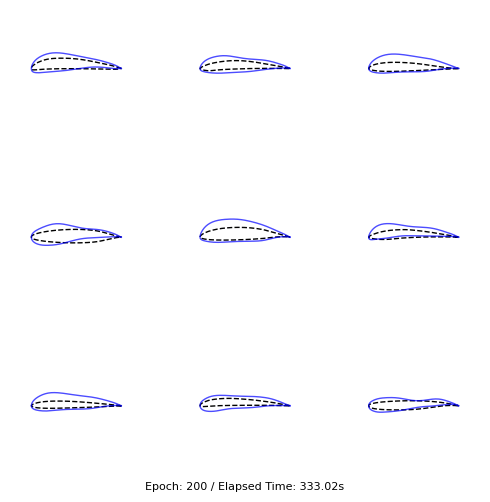

Epoch 201/1000: 100%|██████████| 48/48 [00:01<00:00, 27.76it/s]


Epoch 201/1000, Time: 334.84s, Total Loss: 0.0119, Reco Loss: 0.0078, KL Loss: 4.0964
Generating and plotting airfoils...


Epoch 202/1000: 100%|██████████| 48/48 [00:01<00:00, 28.43it/s]


Epoch 202/1000, Time: 336.56s, Total Loss: 0.0132, Reco Loss: 0.0091, KL Loss: 4.0705
Generating and plotting airfoils...


Epoch 203/1000: 100%|██████████| 48/48 [00:01<00:00, 27.06it/s]


Epoch 203/1000, Time: 338.36s, Total Loss: 0.0133, Reco Loss: 0.0092, KL Loss: 4.0656
Generating and plotting airfoils...


Epoch 204/1000: 100%|██████████| 48/48 [00:01<00:00, 27.38it/s]


Epoch 204/1000, Time: 340.15s, Total Loss: 0.0109, Reco Loss: 0.0068, KL Loss: 4.0990
Generating and plotting airfoils...


Epoch 205/1000: 100%|██████████| 48/48 [00:01<00:00, 28.44it/s]


Epoch 205/1000, Time: 341.87s, Total Loss: 0.0115, Reco Loss: 0.0073, KL Loss: 4.0912
Generating and plotting airfoils...


Epoch 206/1000: 100%|██████████| 48/48 [00:02<00:00, 18.74it/s]


Epoch 206/1000, Time: 344.46s, Total Loss: 0.0103, Reco Loss: 0.0061, KL Loss: 4.0974
Generating and plotting airfoils...


Epoch 207/1000: 100%|██████████| 48/48 [00:00<00:00, -59.15it/s]


Epoch 207/1000, Time: 343.69s, Total Loss: 0.0100, Reco Loss: 0.0058, KL Loss: 4.0910
Generating and plotting airfoils...


Epoch 208/1000: 100%|██████████| 48/48 [00:01<00:00, 28.47it/s]


Epoch 208/1000, Time: 345.40s, Total Loss: 0.0097, Reco Loss: 0.0055, KL Loss: 4.0901
Generating and plotting airfoils...


Epoch 209/1000: 100%|██████████| 48/48 [00:01<00:00, 26.53it/s]


Epoch 209/1000, Time: 347.24s, Total Loss: 0.0095, Reco Loss: 0.0052, KL Loss: 4.0858
Generating and plotting airfoils...


Epoch 210/1000: 100%|██████████| 48/48 [00:01<00:00, 26.90it/s]

Epoch 210/1000, Time: 349.06s, Total Loss: 0.0094, Reco Loss: 0.0051, KL Loss: 4.0972
Generating and plotting airfoils...


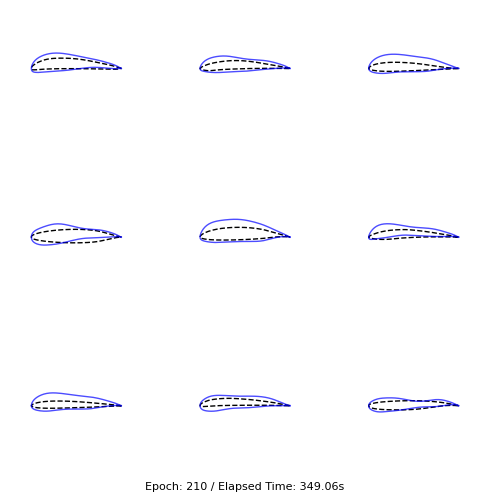

Epoch 211/1000: 100%|██████████| 48/48 [00:01<00:00, 27.47it/s]


Epoch 211/1000, Time: 350.89s, Total Loss: 0.0097, Reco Loss: 0.0054, KL Loss: 4.0775
Generating and plotting airfoils...


Epoch 212/1000: 100%|██████████| 48/48 [00:01<00:00, 26.68it/s]


Epoch 212/1000, Time: 352.72s, Total Loss: 0.0101, Reco Loss: 0.0058, KL Loss: 4.0621
Generating and plotting airfoils...


Epoch 213/1000: 100%|██████████| 48/48 [00:01<00:00, 27.50it/s]


Epoch 213/1000, Time: 354.50s, Total Loss: 0.0113, Reco Loss: 0.0070, KL Loss: 4.0503
Generating and plotting airfoils...


Epoch 214/1000: 100%|██████████| 48/48 [00:01<00:00, 28.14it/s]


Epoch 214/1000, Time: 356.24s, Total Loss: 0.0120, Reco Loss: 0.0077, KL Loss: 4.0484
Generating and plotting airfoils...


Epoch 215/1000: 100%|██████████| 48/48 [00:01<00:00, 28.14it/s]


Epoch 215/1000, Time: 357.97s, Total Loss: 0.0106, Reco Loss: 0.0063, KL Loss: 4.0437
Generating and plotting airfoils...


Epoch 216/1000: 100%|██████████| 48/48 [00:01<00:00, 28.44it/s]


Epoch 216/1000, Time: 359.69s, Total Loss: 0.0109, Reco Loss: 0.0066, KL Loss: 4.0297
Generating and plotting airfoils...


Epoch 217/1000: 100%|██████████| 48/48 [00:01<00:00, 27.49it/s]


Epoch 217/1000, Time: 361.47s, Total Loss: 0.0120, Reco Loss: 0.0076, KL Loss: 4.0161
Generating and plotting airfoils...


Epoch 218/1000: 100%|██████████| 48/48 [00:01<00:00, 27.47it/s]


Epoch 218/1000, Time: 363.25s, Total Loss: 0.0128, Reco Loss: 0.0085, KL Loss: 4.0081
Generating and plotting airfoils...


Epoch 219/1000: 100%|██████████| 48/48 [00:01<00:00, 27.63it/s]


Epoch 219/1000, Time: 365.02s, Total Loss: 0.0148, Reco Loss: 0.0104, KL Loss: 4.0337
Generating and plotting airfoils...


Epoch 220/1000: 100%|██████████| 48/48 [00:01<00:00, 27.96it/s]

Epoch 220/1000, Time: 366.77s, Total Loss: 0.0149, Reco Loss: 0.0104, KL Loss: 4.0501
Generating and plotting airfoils...


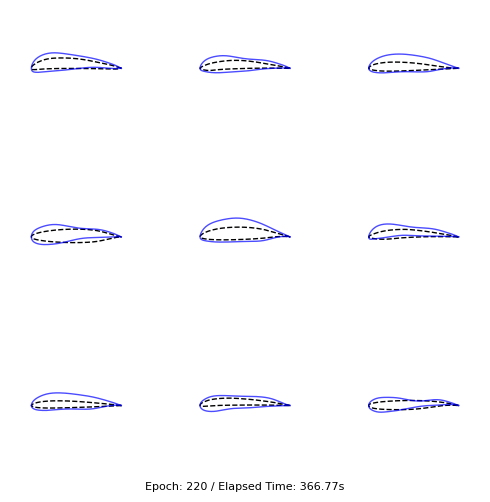

Epoch 221/1000: 100%|██████████| 48/48 [00:01<00:00, 24.42it/s]


Epoch 221/1000, Time: 368.82s, Total Loss: 0.0129, Reco Loss: 0.0084, KL Loss: 4.0680
Generating and plotting airfoils...


Epoch 222/1000: 100%|██████████| 48/48 [00:01<00:00, 27.62it/s]


Epoch 222/1000, Time: 370.59s, Total Loss: 0.0112, Reco Loss: 0.0067, KL Loss: 4.0263
Generating and plotting airfoils...


Epoch 223/1000: 100%|██████████| 48/48 [00:01<00:00, 28.49it/s]


Epoch 223/1000, Time: 372.31s, Total Loss: 0.0105, Reco Loss: 0.0060, KL Loss: 4.0269
Generating and plotting airfoils...


Epoch 224/1000: 100%|██████████| 48/48 [00:01<00:00, 27.52it/s]


Epoch 224/1000, Time: 374.08s, Total Loss: 0.0102, Reco Loss: 0.0057, KL Loss: 4.0150
Generating and plotting airfoils...


Epoch 225/1000: 100%|██████████| 48/48 [00:00<00:00, -53.72it/s]


Epoch 225/1000, Time: 373.22s, Total Loss: 0.0100, Reco Loss: 0.0055, KL Loss: 4.0258
Generating and plotting airfoils...


Epoch 226/1000: 100%|██████████| 48/48 [00:01<00:00, 28.37it/s]


Epoch 226/1000, Time: 374.95s, Total Loss: 0.0104, Reco Loss: 0.0059, KL Loss: 3.9921
Generating and plotting airfoils...


Epoch 227/1000: 100%|██████████| 48/48 [00:01<00:00, 27.24it/s]


Epoch 227/1000, Time: 376.74s, Total Loss: 0.0103, Reco Loss: 0.0058, KL Loss: 4.0071
Generating and plotting airfoils...


Epoch 228/1000: 100%|██████████| 48/48 [00:01<00:00, 27.66it/s]


Epoch 228/1000, Time: 378.51s, Total Loss: 0.0101, Reco Loss: 0.0055, KL Loss: 4.0101
Generating and plotting airfoils...


Epoch 229/1000: 100%|██████████| 48/48 [00:01<00:00, 27.68it/s]


Epoch 229/1000, Time: 380.28s, Total Loss: 0.0110, Reco Loss: 0.0064, KL Loss: 4.0130
Generating and plotting airfoils...


Epoch 230/1000: 100%|██████████| 48/48 [00:01<00:00, 27.66it/s]

Epoch 230/1000, Time: 382.04s, Total Loss: 0.0119, Reco Loss: 0.0073, KL Loss: 3.9953
Generating and plotting airfoils...


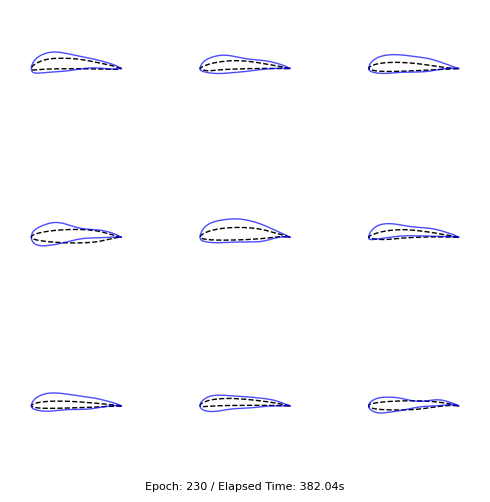

Epoch 231/1000: 100%|██████████| 48/48 [00:01<00:00, 26.82it/s]


Epoch 231/1000, Time: 383.91s, Total Loss: 0.0106, Reco Loss: 0.0060, KL Loss: 3.9854
Generating and plotting airfoils...


Epoch 232/1000: 100%|██████████| 48/48 [00:01<00:00, 28.29it/s]


Epoch 232/1000, Time: 385.65s, Total Loss: 0.0107, Reco Loss: 0.0061, KL Loss: 3.9885
Generating and plotting airfoils...


Epoch 233/1000: 100%|██████████| 48/48 [00:01<00:00, 27.47it/s]


Epoch 233/1000, Time: 387.43s, Total Loss: 0.0111, Reco Loss: 0.0065, KL Loss: 3.9884
Generating and plotting airfoils...


Epoch 234/1000: 100%|██████████| 48/48 [00:01<00:00, 27.41it/s]


Epoch 234/1000, Time: 389.21s, Total Loss: 0.0108, Reco Loss: 0.0062, KL Loss: 4.0060
Generating and plotting airfoils...


Epoch 235/1000: 100%|██████████| 48/48 [00:04<00:00, 11.34it/s]


Epoch 235/1000, Time: 393.48s, Total Loss: 0.0118, Reco Loss: 0.0072, KL Loss: 3.9791
Generating and plotting airfoils...


Epoch 236/1000: 100%|██████████| 48/48 [00:01<00:00, 28.23it/s]


Epoch 236/1000, Time: 395.21s, Total Loss: 0.0120, Reco Loss: 0.0073, KL Loss: 3.9650
Generating and plotting airfoils...


Epoch 237/1000: 100%|██████████| 48/48 [00:01<00:00, 28.06it/s]


Epoch 237/1000, Time: 396.95s, Total Loss: 0.0122, Reco Loss: 0.0075, KL Loss: 3.9602
Generating and plotting airfoils...


Epoch 238/1000: 100%|██████████| 48/48 [00:01<00:00, 27.89it/s]


Epoch 238/1000, Time: 398.71s, Total Loss: 0.0108, Reco Loss: 0.0061, KL Loss: 3.9756
Generating and plotting airfoils...


Epoch 239/1000: 100%|██████████| 48/48 [00:01<00:00, 27.72it/s]


Epoch 239/1000, Time: 400.47s, Total Loss: 0.0121, Reco Loss: 0.0074, KL Loss: 3.9983
Generating and plotting airfoils...


Epoch 240/1000: 100%|██████████| 48/48 [00:01<00:00, 28.21it/s]

Epoch 240/1000, Time: 402.21s, Total Loss: 0.0123, Reco Loss: 0.0075, KL Loss: 3.9724
Generating and plotting airfoils...


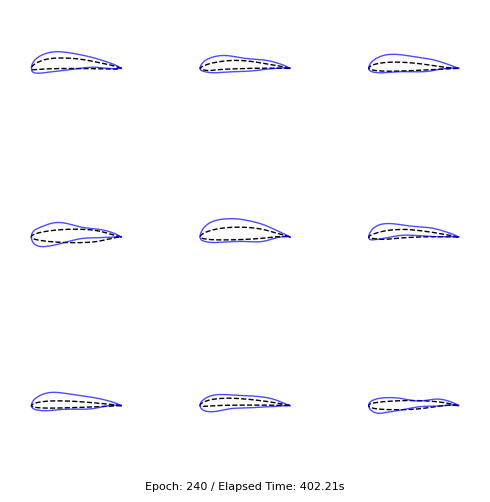

Epoch 241/1000: 100%|██████████| 48/48 [00:01<00:00, 27.61it/s]


Epoch 241/1000, Time: 404.02s, Total Loss: 0.0114, Reco Loss: 0.0067, KL Loss: 3.9613
Generating and plotting airfoils...


Epoch 242/1000: 100%|██████████| 48/48 [00:00<00:00, -69.34it/s]


Epoch 242/1000, Time: 403.36s, Total Loss: 0.0112, Reco Loss: 0.0064, KL Loss: 3.9615
Generating and plotting airfoils...


Epoch 243/1000: 100%|██████████| 48/48 [00:01<00:00, 27.77it/s]


Epoch 243/1000, Time: 405.12s, Total Loss: 0.0104, Reco Loss: 0.0056, KL Loss: 3.9605
Generating and plotting airfoils...


Epoch 244/1000: 100%|██████████| 48/48 [00:01<00:00, 27.36it/s]


Epoch 244/1000, Time: 406.91s, Total Loss: 0.0106, Reco Loss: 0.0058, KL Loss: 3.9697
Generating and plotting airfoils...


Epoch 245/1000: 100%|██████████| 48/48 [00:01<00:00, 26.69it/s]


Epoch 245/1000, Time: 408.74s, Total Loss: 0.0099, Reco Loss: 0.0051, KL Loss: 3.9550
Generating and plotting airfoils...


Epoch 246/1000: 100%|██████████| 48/48 [00:01<00:00, 27.70it/s]


Epoch 246/1000, Time: 410.51s, Total Loss: 0.0099, Reco Loss: 0.0051, KL Loss: 3.9369
Generating and plotting airfoils...


Epoch 247/1000: 100%|██████████| 48/48 [00:01<00:00, 28.26it/s]


Epoch 247/1000, Time: 412.24s, Total Loss: 0.0107, Reco Loss: 0.0058, KL Loss: 3.9554
Generating and plotting airfoils...


Epoch 248/1000: 100%|██████████| 48/48 [00:01<00:00, 27.91it/s]


Epoch 248/1000, Time: 413.99s, Total Loss: 0.0119, Reco Loss: 0.0071, KL Loss: 3.9353
Generating and plotting airfoils...


Epoch 249/1000: 100%|██████████| 48/48 [00:01<00:00, 28.15it/s]


Epoch 249/1000, Time: 415.72s, Total Loss: 0.0111, Reco Loss: 0.0063, KL Loss: 3.9278
Generating and plotting airfoils...


Epoch 250/1000: 100%|██████████| 48/48 [00:01<00:00, 27.68it/s]

Epoch 250/1000, Time: 417.49s, Total Loss: 0.0118, Reco Loss: 0.0069, KL Loss: 3.9183
Generating and plotting airfoils...


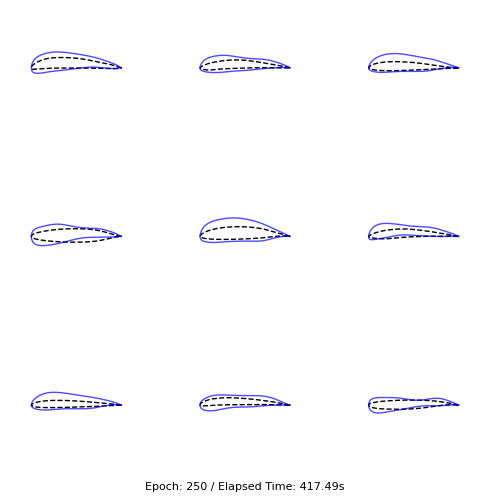

Epoch 251/1000: 100%|██████████| 48/48 [00:01<00:00, 26.71it/s]


Epoch 251/1000, Time: 419.37s, Total Loss: 0.0117, Reco Loss: 0.0067, KL Loss: 3.9322
Generating and plotting airfoils...


Epoch 252/1000: 100%|██████████| 48/48 [00:01<00:00, 27.72it/s]


Epoch 252/1000, Time: 421.13s, Total Loss: 0.0130, Reco Loss: 0.0081, KL Loss: 3.9012
Generating and plotting airfoils...


Epoch 253/1000: 100%|██████████| 48/48 [00:01<00:00, 28.15it/s]


Epoch 253/1000, Time: 422.87s, Total Loss: 0.0135, Reco Loss: 0.0085, KL Loss: 3.9285
Generating and plotting airfoils...


Epoch 254/1000: 100%|██████████| 48/48 [00:01<00:00, 27.68it/s]


Epoch 254/1000, Time: 424.63s, Total Loss: 0.0125, Reco Loss: 0.0076, KL Loss: 3.9331
Generating and plotting airfoils...


Epoch 255/1000: 100%|██████████| 48/48 [00:01<00:00, 27.98it/s]


Epoch 255/1000, Time: 426.38s, Total Loss: 0.0126, Reco Loss: 0.0076, KL Loss: 3.9042
Generating and plotting airfoils...


Epoch 256/1000: 100%|██████████| 48/48 [00:01<00:00, 27.66it/s]


Epoch 256/1000, Time: 428.15s, Total Loss: 0.0127, Reco Loss: 0.0077, KL Loss: 3.9232
Generating and plotting airfoils...


Epoch 257/1000: 100%|██████████| 48/48 [00:01<00:00, 26.07it/s]


Epoch 257/1000, Time: 430.02s, Total Loss: 0.0143, Reco Loss: 0.0093, KL Loss: 3.9236
Generating and plotting airfoils...


Epoch 258/1000: 100%|██████████| 48/48 [00:02<00:00, 18.73it/s]


Epoch 258/1000, Time: 432.62s, Total Loss: 0.0127, Reco Loss: 0.0076, KL Loss: 3.9344
Generating and plotting airfoils...


Epoch 259/1000: 100%|██████████| 48/48 [00:01<00:00, 27.68it/s]


Epoch 259/1000, Time: 434.38s, Total Loss: 0.0117, Reco Loss: 0.0067, KL Loss: 3.9132
Generating and plotting airfoils...


Epoch 260/1000: 100%|██████████| 48/48 [00:00<00:00, -60.93it/s]

Epoch 260/1000, Time: 433.63s, Total Loss: 0.0111, Reco Loss: 0.0060, KL Loss: 3.8993
Generating and plotting airfoils...


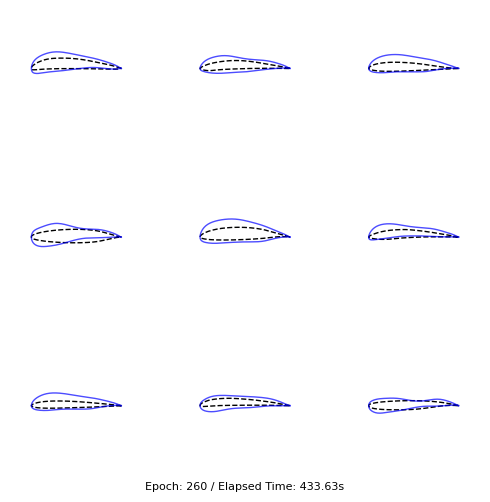

Epoch 261/1000: 100%|██████████| 48/48 [00:01<00:00, 27.58it/s]


Epoch 261/1000, Time: 435.45s, Total Loss: 0.0112, Reco Loss: 0.0062, KL Loss: 3.9123
Generating and plotting airfoils...


Epoch 262/1000: 100%|██████████| 48/48 [00:01<00:00, 26.97it/s]


Epoch 262/1000, Time: 437.26s, Total Loss: 0.0111, Reco Loss: 0.0060, KL Loss: 3.9039
Generating and plotting airfoils...


Epoch 263/1000: 100%|██████████| 48/48 [00:01<00:00, 26.65it/s]


Epoch 263/1000, Time: 439.10s, Total Loss: 0.0114, Reco Loss: 0.0063, KL Loss: 3.8799
Generating and plotting airfoils...


Epoch 264/1000: 100%|██████████| 48/48 [00:01<00:00, 28.01it/s]


Epoch 264/1000, Time: 440.84s, Total Loss: 0.0120, Reco Loss: 0.0069, KL Loss: 3.8715
Generating and plotting airfoils...


Epoch 265/1000: 100%|██████████| 48/48 [00:01<00:00, 27.82it/s]


Epoch 265/1000, Time: 442.60s, Total Loss: 0.0120, Reco Loss: 0.0069, KL Loss: 3.8949
Generating and plotting airfoils...


Epoch 266/1000: 100%|██████████| 48/48 [00:01<00:00, 27.37it/s]


Epoch 266/1000, Time: 444.38s, Total Loss: 0.0117, Reco Loss: 0.0066, KL Loss: 3.8923
Generating and plotting airfoils...


Epoch 267/1000: 100%|██████████| 48/48 [00:01<00:00, 27.69it/s]


Epoch 267/1000, Time: 446.15s, Total Loss: 0.0119, Reco Loss: 0.0068, KL Loss: 3.8865
Generating and plotting airfoils...


Epoch 268/1000: 100%|██████████| 48/48 [00:01<00:00, 26.55it/s]


Epoch 268/1000, Time: 447.99s, Total Loss: 0.0115, Reco Loss: 0.0063, KL Loss: 3.8592
Generating and plotting airfoils...


Epoch 269/1000: 100%|██████████| 48/48 [00:01<00:00, 25.63it/s]


Epoch 269/1000, Time: 449.90s, Total Loss: 0.0128, Reco Loss: 0.0076, KL Loss: 3.8668
Generating and plotting airfoils...


Epoch 270/1000: 100%|██████████| 48/48 [00:01<00:00, 27.34it/s]

Epoch 270/1000, Time: 451.69s, Total Loss: 0.0139, Reco Loss: 0.0087, KL Loss: 3.8693
Generating and plotting airfoils...


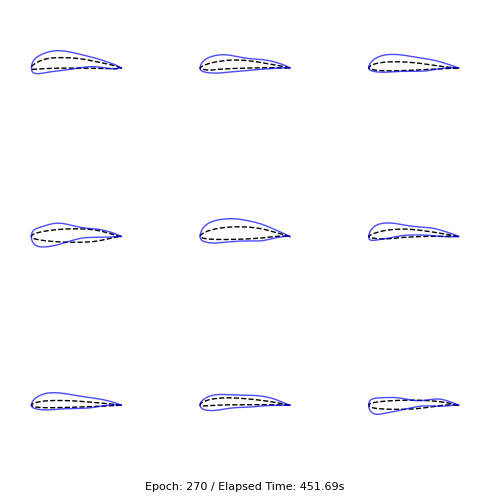

Epoch 271/1000: 100%|██████████| 48/48 [00:01<00:00, 27.11it/s]


Epoch 271/1000, Time: 453.54s, Total Loss: 0.0130, Reco Loss: 0.0077, KL Loss: 3.8869
Generating and plotting airfoils...


Epoch 272/1000: 100%|██████████| 48/48 [00:01<00:00, 27.09it/s]


Epoch 272/1000, Time: 455.34s, Total Loss: 0.0127, Reco Loss: 0.0074, KL Loss: 3.8580
Generating and plotting airfoils...


Epoch 273/1000: 100%|██████████| 48/48 [00:01<00:00, 26.95it/s]


Epoch 273/1000, Time: 457.15s, Total Loss: 0.0118, Reco Loss: 0.0066, KL Loss: 3.8798
Generating and plotting airfoils...


Epoch 274/1000: 100%|██████████| 48/48 [00:01<00:00, 26.05it/s]


Epoch 274/1000, Time: 459.03s, Total Loss: 0.0120, Reco Loss: 0.0067, KL Loss: 3.8631
Generating and plotting airfoils...


Epoch 275/1000: 100%|██████████| 48/48 [00:01<00:00, 26.26it/s]


Epoch 275/1000, Time: 460.89s, Total Loss: 0.0113, Reco Loss: 0.0060, KL Loss: 3.8578
Generating and plotting airfoils...


Epoch 276/1000: 100%|██████████| 48/48 [00:01<00:00, 27.62it/s]


Epoch 276/1000, Time: 462.66s, Total Loss: 0.0114, Reco Loss: 0.0062, KL Loss: 3.8293
Generating and plotting airfoils...


Epoch 277/1000: 100%|██████████| 48/48 [00:01<00:00, 27.51it/s]


Epoch 277/1000, Time: 464.43s, Total Loss: 0.0115, Reco Loss: 0.0062, KL Loss: 3.8428
Generating and plotting airfoils...


Epoch 278/1000: 100%|██████████| 48/48 [00:00<00:00, -61.50it/s]


Epoch 278/1000, Time: 463.68s, Total Loss: 0.0121, Reco Loss: 0.0068, KL Loss: 3.8776
Generating and plotting airfoils...


Epoch 279/1000: 100%|██████████| 48/48 [00:01<00:00, 26.79it/s]


Epoch 279/1000, Time: 465.51s, Total Loss: 0.0111, Reco Loss: 0.0057, KL Loss: 3.8597
Generating and plotting airfoils...


Epoch 280/1000: 100%|██████████| 48/48 [00:01<00:00, 25.08it/s]

Epoch 280/1000, Time: 467.46s, Total Loss: 0.0108, Reco Loss: 0.0055, KL Loss: 3.8195
Generating and plotting airfoils...


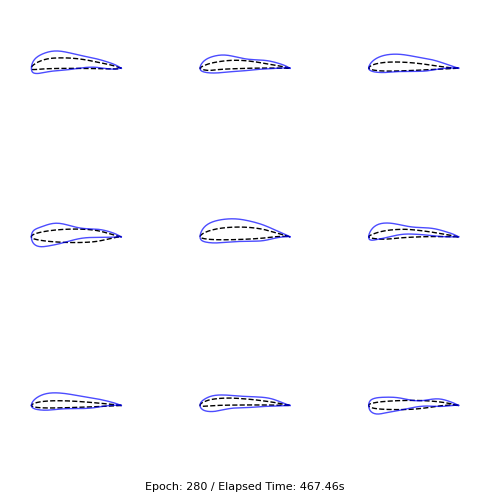

Epoch 281/1000: 100%|██████████| 48/48 [00:01<00:00, 26.60it/s]


Epoch 281/1000, Time: 469.37s, Total Loss: 0.0109, Reco Loss: 0.0056, KL Loss: 3.8358
Generating and plotting airfoils...


Epoch 282/1000: 100%|██████████| 48/48 [00:01<00:00, 25.07it/s]


Epoch 282/1000, Time: 471.31s, Total Loss: 0.0109, Reco Loss: 0.0055, KL Loss: 3.8164
Generating and plotting airfoils...


Epoch 283/1000: 100%|██████████| 48/48 [00:01<00:00, 25.35it/s]


Epoch 283/1000, Time: 473.24s, Total Loss: 0.0108, Reco Loss: 0.0054, KL Loss: 3.8258
Generating and plotting airfoils...


Epoch 284/1000: 100%|██████████| 48/48 [00:01<00:00, 26.19it/s]


Epoch 284/1000, Time: 475.10s, Total Loss: 0.0111, Reco Loss: 0.0057, KL Loss: 3.8090
Generating and plotting airfoils...


Epoch 285/1000: 100%|██████████| 48/48 [00:01<00:00, 26.23it/s]


Epoch 285/1000, Time: 476.97s, Total Loss: 0.0106, Reco Loss: 0.0052, KL Loss: 3.8344
Generating and plotting airfoils...


Epoch 286/1000: 100%|██████████| 48/48 [00:01<00:00, 25.88it/s]


Epoch 286/1000, Time: 478.85s, Total Loss: 0.0112, Reco Loss: 0.0058, KL Loss: 3.8208
Generating and plotting airfoils...


Epoch 287/1000: 100%|██████████| 48/48 [00:01<00:00, 24.49it/s]


Epoch 287/1000, Time: 480.85s, Total Loss: 0.0116, Reco Loss: 0.0061, KL Loss: 3.8317
Generating and plotting airfoils...


Epoch 288/1000: 100%|██████████| 48/48 [00:01<00:00, 25.67it/s]


Epoch 288/1000, Time: 482.75s, Total Loss: 0.0135, Reco Loss: 0.0080, KL Loss: 3.8287
Generating and plotting airfoils...


Epoch 289/1000: 100%|██████████| 48/48 [00:01<00:00, 25.69it/s]


Epoch 289/1000, Time: 484.66s, Total Loss: 0.0162, Reco Loss: 0.0107, KL Loss: 3.8231
Generating and plotting airfoils...


Epoch 290/1000: 100%|██████████| 48/48 [00:01<00:00, 25.36it/s]

Epoch 290/1000, Time: 486.58s, Total Loss: 0.0161, Reco Loss: 0.0106, KL Loss: 3.7983
Generating and plotting airfoils...


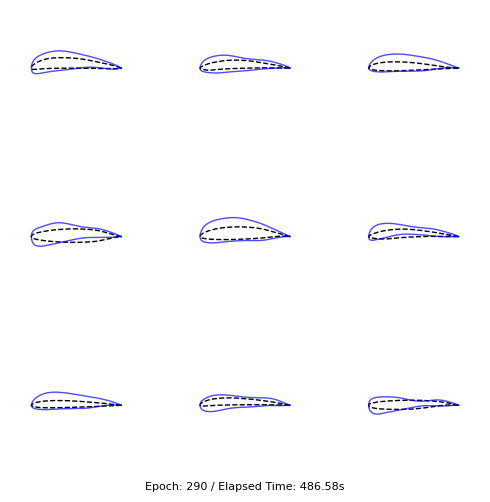

Epoch 291/1000: 100%|██████████| 48/48 [00:01<00:00, 25.01it/s]


Epoch 291/1000, Time: 488.60s, Total Loss: 0.0154, Reco Loss: 0.0099, KL Loss: 3.7959
Generating and plotting airfoils...


Epoch 292/1000: 100%|██████████| 48/48 [00:02<00:00, 23.14it/s]


Epoch 292/1000, Time: 490.71s, Total Loss: 0.0121, Reco Loss: 0.0065, KL Loss: 3.8315
Generating and plotting airfoils...


Epoch 293/1000: 100%|██████████| 48/48 [00:01<00:00, 24.82it/s]


Epoch 293/1000, Time: 492.68s, Total Loss: 0.0120, Reco Loss: 0.0064, KL Loss: 3.8124
Generating and plotting airfoils...


Epoch 294/1000: 100%|██████████| 48/48 [00:00<00:00, -97.20it/s]


Epoch 294/1000, Time: 492.22s, Total Loss: 0.0114, Reco Loss: 0.0058, KL Loss: 3.8145
Generating and plotting airfoils...


Epoch 295/1000: 100%|██████████| 48/48 [00:01<00:00, 24.77it/s]


Epoch 295/1000, Time: 494.20s, Total Loss: 0.0111, Reco Loss: 0.0055, KL Loss: 3.7866
Generating and plotting airfoils...


Epoch 296/1000: 100%|██████████| 48/48 [00:02<00:00, 22.86it/s]


Epoch 296/1000, Time: 496.33s, Total Loss: 0.0114, Reco Loss: 0.0058, KL Loss: 3.7911
Generating and plotting airfoils...


Epoch 297/1000: 100%|██████████| 48/48 [00:01<00:00, 25.65it/s]


Epoch 297/1000, Time: 498.24s, Total Loss: 0.0115, Reco Loss: 0.0059, KL Loss: 3.7921
Generating and plotting airfoils...


Epoch 298/1000: 100%|██████████| 48/48 [00:01<00:00, 26.32it/s]


Epoch 298/1000, Time: 500.11s, Total Loss: 0.0137, Reco Loss: 0.0080, KL Loss: 3.8011
Generating and plotting airfoils...


Epoch 299/1000: 100%|██████████| 48/48 [00:01<00:00, 25.90it/s]


Epoch 299/1000, Time: 501.99s, Total Loss: 0.0130, Reco Loss: 0.0074, KL Loss: 3.7835
Generating and plotting airfoils...


Epoch 300/1000: 100%|██████████| 48/48 [00:01<00:00, 26.09it/s]

Epoch 300/1000, Time: 503.87s, Total Loss: 0.0127, Reco Loss: 0.0070, KL Loss: 3.7989
Generating and plotting airfoils...


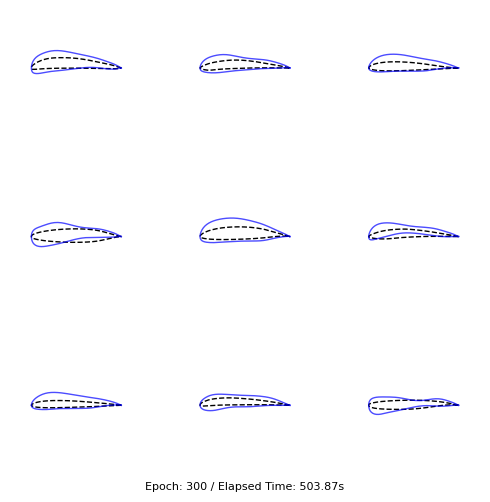

Epoch 301/1000: 100%|██████████| 48/48 [00:01<00:00, 24.16it/s]


Epoch 301/1000, Time: 505.95s, Total Loss: 0.0122, Reco Loss: 0.0066, KL Loss: 3.7847
Generating and plotting airfoils...


Epoch 302/1000: 100%|██████████| 48/48 [00:01<00:00, 24.78it/s]


Epoch 302/1000, Time: 507.92s, Total Loss: 0.0124, Reco Loss: 0.0067, KL Loss: 3.7762
Generating and plotting airfoils...


Epoch 303/1000: 100%|██████████| 48/48 [00:02<00:00, 23.57it/s]


Epoch 303/1000, Time: 509.99s, Total Loss: 0.0120, Reco Loss: 0.0063, KL Loss: 3.7857
Generating and plotting airfoils...


Epoch 304/1000: 100%|██████████| 48/48 [00:15<00:00,  3.03it/s]


Epoch 304/1000, Time: 525.88s, Total Loss: 0.0117, Reco Loss: 0.0059, KL Loss: 3.7931
Generating and plotting airfoils...


Epoch 305/1000: 100%|██████████| 48/48 [00:02<00:00, 22.98it/s]


Epoch 305/1000, Time: 528.01s, Total Loss: 0.0122, Reco Loss: 0.0065, KL Loss: 3.7547
Generating and plotting airfoils...


Epoch 306/1000: 100%|██████████| 48/48 [00:02<00:00, 20.46it/s]


Epoch 306/1000, Time: 530.39s, Total Loss: 0.0110, Reco Loss: 0.0053, KL Loss: 3.7707
Generating and plotting airfoils...


Epoch 307/1000: 100%|██████████| 48/48 [00:02<00:00, 22.91it/s]


Epoch 307/1000, Time: 532.52s, Total Loss: 0.0115, Reco Loss: 0.0057, KL Loss: 3.7689
Generating and plotting airfoils...


Epoch 308/1000: 100%|██████████| 48/48 [00:05<00:00,  9.12it/s]


Epoch 308/1000, Time: 537.82s, Total Loss: 0.0126, Reco Loss: 0.0068, KL Loss: 3.7514
Generating and plotting airfoils...


Epoch 309/1000: 100%|██████████| 48/48 [00:01<00:00, 24.10it/s]


Epoch 309/1000, Time: 539.85s, Total Loss: 0.0122, Reco Loss: 0.0065, KL Loss: 3.7532
Generating and plotting airfoils...


Epoch 310/1000: 100%|██████████| 48/48 [00:01<00:00, 24.48it/s]

Epoch 310/1000, Time: 541.84s, Total Loss: 0.0118, Reco Loss: 0.0060, KL Loss: 3.7533
Generating and plotting airfoils...


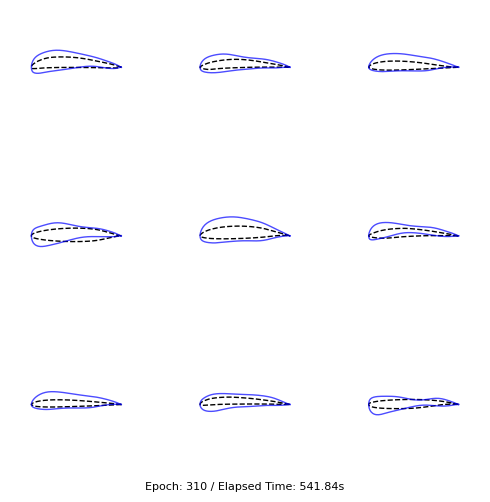

Epoch 311/1000: 100%|██████████| 48/48 [00:01<00:00, 26.82it/s]


Epoch 311/1000, Time: 543.73s, Total Loss: 0.0123, Reco Loss: 0.0065, KL Loss: 3.7209
Generating and plotting airfoils...


Epoch 312/1000: 100%|██████████| 48/48 [00:01<00:00, 27.13it/s]


Epoch 312/1000, Time: 545.53s, Total Loss: 0.0125, Reco Loss: 0.0067, KL Loss: 3.7349
Generating and plotting airfoils...


Epoch 313/1000: 100%|██████████| 48/48 [00:01<00:00, 26.24it/s]


Epoch 313/1000, Time: 547.39s, Total Loss: 0.0124, Reco Loss: 0.0065, KL Loss: 3.7666
Generating and plotting airfoils...


Epoch 314/1000: 100%|██████████| 48/48 [00:01<00:00, 27.02it/s]


Epoch 314/1000, Time: 549.20s, Total Loss: 0.0125, Reco Loss: 0.0067, KL Loss: 3.7364
Generating and plotting airfoils...


Epoch 315/1000: 100%|██████████| 48/48 [00:01<00:00, 25.98it/s]


Epoch 315/1000, Time: 551.08s, Total Loss: 0.0117, Reco Loss: 0.0059, KL Loss: 3.7484
Generating and plotting airfoils...


Epoch 316/1000: 100%|██████████| 48/48 [00:01<00:00, 25.14it/s]


Epoch 316/1000, Time: 553.02s, Total Loss: 0.0118, Reco Loss: 0.0059, KL Loss: 3.7476
Generating and plotting airfoils...


Epoch 317/1000: 100%|██████████| 48/48 [00:00<00:00, -80.26it/s]


Epoch 317/1000, Time: 552.46s, Total Loss: 0.0133, Reco Loss: 0.0074, KL Loss: 3.7385
Generating and plotting airfoils...


Epoch 318/1000: 100%|██████████| 48/48 [00:01<00:00, 25.38it/s]


Epoch 318/1000, Time: 554.38s, Total Loss: 0.0127, Reco Loss: 0.0068, KL Loss: 3.7247
Generating and plotting airfoils...


Epoch 319/1000: 100%|██████████| 48/48 [00:09<00:00,  4.93it/s]


Epoch 319/1000, Time: 564.29s, Total Loss: 0.0120, Reco Loss: 0.0060, KL Loss: 3.7320
Generating and plotting airfoils...


Epoch 320/1000: 100%|██████████| 48/48 [00:06<00:00,  7.99it/s]

Epoch 320/1000, Time: 570.55s, Total Loss: 0.0117, Reco Loss: 0.0058, KL Loss: 3.7511
Generating and plotting airfoils...


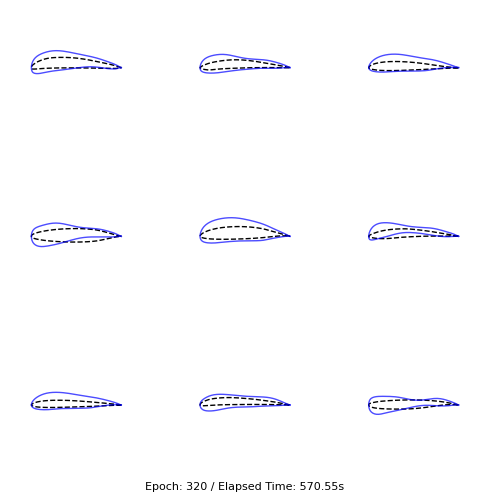

Epoch 321/1000: 100%|██████████| 48/48 [00:11<00:00,  4.22it/s]


Epoch 321/1000, Time: 582.18s, Total Loss: 0.0112, Reco Loss: 0.0053, KL Loss: 3.7208
Generating and plotting airfoils...


Epoch 322/1000: 100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


Epoch 322/1000, Time: 624.26s, Total Loss: 0.0114, Reco Loss: 0.0054, KL Loss: 3.7126
Generating and plotting airfoils...


Epoch 323/1000: 100%|██████████| 48/48 [00:02<00:00, 18.47it/s]


Epoch 323/1000, Time: 627.11s, Total Loss: 0.0119, Reco Loss: 0.0059, KL Loss: 3.7246
Generating and plotting airfoils...


Epoch 324/1000: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


Epoch 324/1000, Time: 671.67s, Total Loss: 0.0121, Reco Loss: 0.0061, KL Loss: 3.7183
Generating and plotting airfoils...


Epoch 325/1000: 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Epoch 325/1000, Time: 704.36s, Total Loss: 0.0118, Reco Loss: 0.0058, KL Loss: 3.6954
Generating and plotting airfoils...


Epoch 326/1000: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


Epoch 326/1000, Time: 749.59s, Total Loss: 0.0121, Reco Loss: 0.0061, KL Loss: 3.7232
Generating and plotting airfoils...


Epoch 327/1000: 100%|██████████| 48/48 [03:25<00:00,  4.28s/it]


Epoch 327/1000, Time: 975.73s, Total Loss: 0.0115, Reco Loss: 0.0055, KL Loss: 3.7086
Generating and plotting airfoils...


Epoch 328/1000: 100%|██████████| 48/48 [02:04<00:00,  2.59s/it] 


Epoch 328/1000, Time: 1119.24s, Total Loss: 0.0131, Reco Loss: 0.0071, KL Loss: 3.7075
Generating and plotting airfoils...


Epoch 329/1000:   0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
wandb.init(
    project="CSTVAE",  
    config=HYPERPARAMETERS,
    name=f"VAE_{time.strftime('%Y%m%d-%H%M%S')}",
    notes="Dense Arch + Linear Output + Sum Loss + Scaler"
)

VERBOSE = 1

# Ensure the models directory exists
models_path = Path(proj_path) / "models" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
images_path = Path(proj_path) / "images" / "cstvae" / time.strftime("%Y%m%d-%H%M%S")
os.makedirs(models_path, exist_ok=True)
os.makedirs(images_path, exist_ok=True)

# --- The Main Training Loop ---
print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
    
    # Reset metrics at the start of each epoch
    epoch_total_loss = tf.keras.metrics.Mean()
    epoch_reco_loss = tf.keras.metrics.Mean()
    epoch_kl_loss = tf.keras.metrics.Mean()

    # Linear ramp for BETA
    if epoch < WARMUP_EPOCHS:
        BETA = TARGET_BETA * (epoch / WARMUP_EPOCHS)
    else:
        BETA = TARGET_BETA
    
    wandb.log({'beta': BETA})

    # Iterate over each batch in the dataset
    for x_batch in tqdm(train_dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):

        # Run one training step
        total_loss, reco_loss, kl_loss = train_step(x_batch, BETA)
        
        # Update the epoch's average loss
        epoch_total_loss.update_state(total_loss)
        epoch_reco_loss.update_state(reco_loss)
        epoch_kl_loss.update_state(kl_loss)
    
    # current_loss = epoch_total_loss.result().numpy()

    # if current_loss < (best_loss - MIN_DELTA):
    #     best_loss = current_loss
    #     wait = 0 # Resetar espera se melhorou
    # else:
    #     wait += 1 # Contar épocas sem melhoria
    #     if wait >= PATIENCE:
    #         # Reduzir Learning Rate
    #         old_lr = float(optimizer.learning_rate.numpy())
    #         new_lr = old_lr * DECAY_FACTOR
            
    #         # Trava de segurança para não ficar minúsculo
    #         if new_lr > 1e-6:
    #             optimizer.learning_rate.assign(new_lr)
    #             print(f"\n⚠️ Platô detectado! Reduzindo LR: {old_lr:.1e} -> {new_lr:.1e}")
    #             wait = 0 

    current_lr_val = float(optimizer.learning_rate.numpy())

    # --- End of Epoch ---
    elapsed_time = time.time() - start_time
    
    if VERBOSE > 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, "
              f"Time: {elapsed_time:.2f}s, "
              f"Total Loss: {epoch_total_loss.result():.4f}, "
              f"Reco Loss: {epoch_reco_loss.result():.4f}, "
              f"KL Loss: {epoch_kl_loss.result():.4f}")
    
    wandb.log({
        'epoch_total_loss': epoch_total_loss.result(),
        'epoch_reconstruction_loss': epoch_reco_loss.result(),
        'epoch_kl_loss': epoch_kl_loss.result(),
        'learning_rate': current_lr_val
    })

    print("Generating and plotting airfoils...")

    # 1. Get Normalized Predictions
    # CRITICAL: training=False disables noise for smooth plots
    # Ensure input is a Tensor (Fixes the ValueError)
    val_input_tensor = tf.convert_to_tensor(validation_input)
    _, reco_weights_norm, reco_params_norm = vae(val_input_tensor, training=False)

    # 2. Denormalize to Physical Values
    real_reco_weights, real_reco_params = vae.scaler.inverse_transform(
        reco_weights_norm.numpy(), 
        reco_params_norm.numpy()
    )

    # 3. Generate Coordinates using the Model's Internal Logic
    w_tensor = tf.convert_to_tensor(real_reco_weights, dtype=tf.float32)
    p_tensor = tf.convert_to_tensor(real_reco_params, dtype=tf.float32)

    # This generates (Batch, Points, 2)
    reco_coords = vae.decoder.cst_transform(w_tensor, p_tensor).numpy()

    # 4. Wrap in Airfoil objects for your plotting function
    reconstructed_airfoils = []
    for coords in reco_coords:
        reconstructed_airfoils.append(Airfoil(coordinates=coords))

    # Save model checkpoints every 5 epochs
    if (epoch + 1) % 10 == 0:
        # print(f"--- Saving model checkpoint for epoch {epoch+1} ---")
        # vae.save_weights(f"{models_path}/model_epoch_{epoch+1}.weights.h5")

        plot_original_and_reconstruction(
            validation_airfoils, 
            reconstructed_airfoils, 
            text_label=f"Epoch: {epoch+1} / Elapsed Time: {elapsed_time:.2f}s", 
            save_path=images_path, 
            filename=f"reconstruction_epoch_{epoch+1}.png"
        )

    # Reconstructing initial validation airfoils
    # reco_coords, _, _ = vae(validation_input, training=False)
    # reco_airfoils = [Airfoil(coordinates=coords).to_kulfan_airfoil(NPV) for coords in np.array(reco_coords)]
    # _, reco_weights, reco_params = vae(validation_input, training=False)

    # # Assuming you have already run:
    # real_reco_weights, real_reco_params = vae.scaler.inverse_transform(reco_weights.numpy(), reco_params.numpy())

    # reconstructed_airfoils = []

    # for i in range(len(real_reco_weights)):
    #     # 1. Extract Weights for this sample
    #     # Shape of real_reco_weights is likely (Batch, 2, NPV)
    #     # Row 0 = Lower Surface, Row 1 = Upper Surface
    #     lower_w = real_reco_weights[i][0] 
    #     upper_w = real_reco_weights[i][1]
        
    #     # 2. Extract Parameters for this sample
    #     # Based on your data loading order: [TE_thickness, leading_edge_weight]
    #     te_thickness = real_reco_params[i][0]
    #     le_weight = real_reco_params[i][1]
        
    #     # 3. Instantiate KulfanAirfoil
    #     # Note: Ensure arguments match the library's definition
    #     kulfan_af = KulfanAirfoil(
    #         name=f"Reconstructed_{i}",
    #         lower_weights=lower_w,
    #         upper_weights=upper_w,
    #         leading_edge_weight=le_weight,
    #         TE_thickness=te_thickness
    #     )
        
    #     reconstructed_airfoils.append(kulfan_af)

    # real_reco_weights, real_reco_params = vae.scaler.inverse_transform(reco_weights.numpy(), reco_params.numpy())

    # # reco_airfoils = [Airfoil(coordinates=coords).to_kulfan_airfoil(NPV) for coords in np.array(reco_coords)]
    
    # plot_original_and_reconstruction(validation_airfoils, reconstructed_airfoils, text_label=f"Epoch: {epoch+1} / Elapsed Time: {elapsed_time:.2f}s", save_path=images_path, filename=f"reconstruction_epoch_{epoch+1}.png")

    # # generate_and_plot_airfoils(
    # #     vae.decoder, # Note: we pass vae.decoder, not a 'generator'
    # #     epoch=epoch, 
    # #     time=elapsed_time,
    # #     save_path=images_path,
    # #     show=True,
    # #     dpi=200
    # # )

    # # Save model checkpoints every 5 epochs
    # if (epoch + 1) % 5 == 0:
    #     print(f"--- Saving model checkpoint for epoch {epoch+1} ---")
    #     # vae.save(f"{models_path}/model_epoch_{epoch+1}.keras")
    #     vae.save_weights(f"{models_path}/model_epoch_{epoch+1}.weights.h5")

print("Training complete.")

In [ ]:
import glob
from PIL import Image
from IPython.display import Image as IPImage # Use an alias to avoid name conflict

# image_path_path = Path(proj_path) / "images" / "cstvae" / "20251122-004235"

# --- Step 1: Find your image files ---
image_folder_path = str(images_path) + "/*.png"

# Get a *sorted* list of file paths.
# Sorting is CRITICAL to make sure your frames are in the right order.
file_paths = sorted(glob.glob(image_folder_path + "/*.png"))

# --- Step 2: Load the images ---
# Open the first image, and then all the subsequent images
images = [Image.open(fp) for fp in file_paths]
first_image = images[0]
other_images = images[1:]

# --- Step 3: Save the images as a GIF ---
gif_path = str(images_path) + "/animated.gif"

first_image.save(
    gif_path,
    format="GIF",
    append_images=other_images,  # The list of images to append
    save_all=True,
    duration=100,                # Milliseconds per frame (e.g., 100ms = 10 fps)
    loop=0                       # 0 = loop forever
)

# --- Step 4: Display the GIF in Jupyter ---
# This will embed the GIF directly into your notebook output
IPImage(filename=gif_path)

NameError: name 'Path' is not defined